In [1]:
#80
#途中まで50と同じ

#データダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-01-30 16:12:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  14.8MB/s    in 1.9s    

2022-01-30 16:12:29 (14.8 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']) #具体例からこのように分ける

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']] #publisherが”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”であるものの、そのカテゴリ名と記事見出しを抽出 isin https://vector-ium.com/pandas-isin/  loc(列ラベル) https://note.nkmk.me/python-pandas-at-iat-loc-iloc/

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['CATEGORY']) #学習データ80%とその他20%に分ける train_test_splitについて https://qiita.com/KyleKatarn/items/2afa6787f04f28e2cd2d
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=42, stratify=valid_test['CATEGORY']) #その他に分けられたデータを半分ずつ検証データと評価データに分類(全体から見ると10%,10%)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


# データの保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [87]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id.values()))}\n')
print('---頻度上位20語---')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]} 出現回数:{d[word2id[key]-1][1]}')

ID数: 9374

---頻度上位20語---
to: 1 出現回数:2141
s: 2 出現回数:1907
in: 3 出現回数:1423
UPDATE: 4 出現回数:1074
on: 5 出現回数:1065
as: 6 出現回数:1018
US: 7 出現回数:998
The: 8 出現回数:975
of: 9 出現回数:967
for: 10 出現回数:942
1: 11 出現回数:860
To: 12 出現回数:737
2: 13 出現回数:678
the: 14 出現回数:611
and: 15 出現回数:577
In: 16 出現回数:509
Of: 17 出現回数:478
at: 18 出現回数:466
a: 19 出現回数:449
A: 20 出現回数:442


### defaultdictについて
https://qiita.com/xza/items/

In [88]:
def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]

In [89]:
#確認
text = train.iloc[0, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: UPDATE 1-Sandwich chain Quiznos files for bankruptcy protection
ID列: [4, 11, 0, 1717, 0, 790, 10, 1238, 3532]


In [90]:
#81
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out
    
  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
    return hidden

In [91]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer(text)

    return {
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

In [92]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 195,  557, 1078,  389, 3022,   87,  288,  605,   94,   41, 2657,  214])
  labels: 0


In [93]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# デバイスの指定
device = torch.device("cpu")

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.1527, 0.4365, 0.2839, 0.1269]], grad_fn=<SoftmaxBackward>)
tensor([[0.2758, 0.2125, 0.2151, 0.2966]], grad_fn=<SoftmaxBackward>)
tensor([[0.2699, 0.1248, 0.5023, 0.1029]], grad_fn=<SoftmaxBackward>)
tensor([[0.3940, 0.2081, 0.1415, 0.2565]], grad_fn=<SoftmaxBackward>)
tensor([[0.1871, 0.3347, 0.1696, 0.3087]], grad_fn=<SoftmaxBackward>)
tensor([[0.2153, 0.1828, 0.4785, 0.1234]], grad_fn=<SoftmaxBackward>)
tensor([[0.1386, 0.2246, 0.4546, 0.1823]], grad_fn=<SoftmaxBackward>)
tensor([[0.2677, 0.3369, 0.2052, 0.1902]], grad_fn=<SoftmaxBackward>)
tensor([[0.2315, 0.1447, 0.3648, 0.2590]], grad_fn=<SoftmaxBackward>)
tensor([[0.3049, 0.1950, 0.2513, 0.2488]], grad_fn=<SoftmaxBackward>)


In [11]:
#82
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
        
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [12]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [13]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device("cpu")

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

epoch: 1, loss_train: 1.1052, accuracy_train: 0.5209, loss_valid: 1.1255, accuracy_valid: 0.5195, 65.5820sec
epoch: 2, loss_train: 1.0197, accuracy_train: 0.5899, loss_valid: 1.0633, accuracy_valid: 0.5726, 70.7429sec
epoch: 3, loss_train: 0.8792, accuracy_train: 0.6722, loss_valid: 0.9464, accuracy_valid: 0.6497, 64.4233sec
epoch: 4, loss_train: 0.7269, accuracy_train: 0.7397, loss_valid: 0.8351, accuracy_valid: 0.7021, 71.4232sec
epoch: 5, loss_train: 0.6323, accuracy_train: 0.7756, loss_valid: 0.7665, accuracy_valid: 0.7320, 63.7325sec
epoch: 6, loss_train: 0.5615, accuracy_train: 0.7974, loss_valid: 0.7191, accuracy_valid: 0.7433, 72.6375sec
epoch: 7, loss_train: 0.5074, accuracy_train: 0.8157, loss_valid: 0.6877, accuracy_valid: 0.7493, 72.9867sec
epoch: 8, loss_train: 0.4868, accuracy_train: 0.8230, loss_valid: 0.6816, accuracy_valid: 0.7575, 72.8820sec
epoch: 9, loss_train: 0.4644, accuracy_train: 0.8327, loss_valid: 0.6739, accuracy_valid: 0.7552, 63.5258sec
epoch: 10, loss_tra

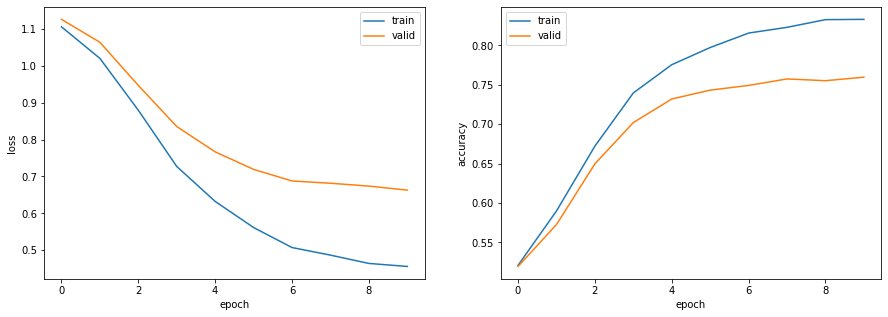

正解率（学習データ）：0.833
正解率（評価データ）：0.772


In [14]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [15]:
#83
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

## GPUの確認

In [16]:
!nvidia-smi

Sun Jan 30 16:24:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN X ...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   24C    P8     8W / 250W |      8MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN X ...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [17]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device("cuda")

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2604, accuracy_train: 0.4056, loss_valid: 1.2629, accuracy_valid: 0.4072, 10.0428sec
epoch: 2, loss_train: 1.2696, accuracy_train: 0.4086, loss_valid: 1.2843, accuracy_valid: 0.4019, 10.0283sec
epoch: 3, loss_train: 1.1659, accuracy_train: 0.4963, loss_valid: 1.1762, accuracy_valid: 0.4798, 9.9935sec
epoch: 4, loss_train: 1.0956, accuracy_train: 0.5671, loss_valid: 1.1211, accuracy_valid: 0.5240, 10.1462sec
epoch: 5, loss_train: 1.0144, accuracy_train: 0.6353, loss_valid: 1.0663, accuracy_valid: 0.5861, 10.7708sec
epoch: 6, loss_train: 0.9934, accuracy_train: 0.6465, loss_valid: 1.0409, accuracy_valid: 0.5921, 10.7953sec
epoch: 7, loss_train: 0.9584, accuracy_train: 0.6660, loss_valid: 1.0156, accuracy_valid: 0.6115, 10.1055sec
epoch: 8, loss_train: 0.9278, accuracy_train: 0.6846, loss_valid: 0.9840, accuracy_valid: 0.6295, 10.0323sec
epoch: 9, loss_train: 0.8989, accuracy_train: 0.6982, loss_valid: 0.9677, accuracy_valid: 0.6310, 10.0533sec
epoch: 10, loss_trai

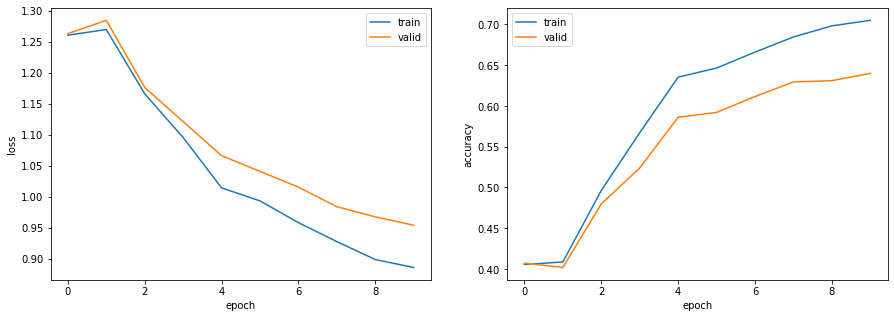

正解率（学習データ）：0.705
正解率（評価データ）：0.661


In [18]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [19]:
#84
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2022-01-30 16:26:08--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.73.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.73.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  17.4MB/s    in 1m 55s  

2022-01-30 16:28:03 (13.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [20]:
!pip install gensim

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 24.1 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 11.4 MB/s eta 0:00:01
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [21]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = torch.tensor(model[word])
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9130 / 9375
torch.Size([9375, 300])


In [22]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden() # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(device)
    return hidden

In [23]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1695, accuracy_train: 0.4334, loss_valid: 1.1703, accuracy_valid: 0.4341, 10.5173sec
epoch: 2, loss_train: 1.1243, accuracy_train: 0.5177, loss_valid: 1.1461, accuracy_valid: 0.4955, 10.2129sec
epoch: 3, loss_train: 1.0495, accuracy_train: 0.6012, loss_valid: 1.0725, accuracy_valid: 0.5793, 10.1368sec
epoch: 4, loss_train: 1.0171, accuracy_train: 0.6340, loss_valid: 1.0453, accuracy_valid: 0.6055, 10.1480sec
epoch: 5, loss_train: 1.0453, accuracy_train: 0.6014, loss_valid: 1.0933, accuracy_valid: 0.5786, 10.1659sec
epoch: 6, loss_train: 1.0462, accuracy_train: 0.5979, loss_valid: 1.0806, accuracy_valid: 0.5734, 10.1781sec
epoch: 7, loss_train: 0.9947, accuracy_train: 0.6326, loss_valid: 1.0390, accuracy_valid: 0.6018, 10.1465sec
epoch: 8, loss_train: 0.9435, accuracy_train: 0.6628, loss_valid: 0.9770, accuracy_valid: 0.6400, 10.1524sec
epoch: 9, loss_train: 0.9380, accuracy_train: 0.6633, loss_valid: 0.9788, accuracy_valid: 0.6317, 10.1998sec
epoch: 10, loss_tra

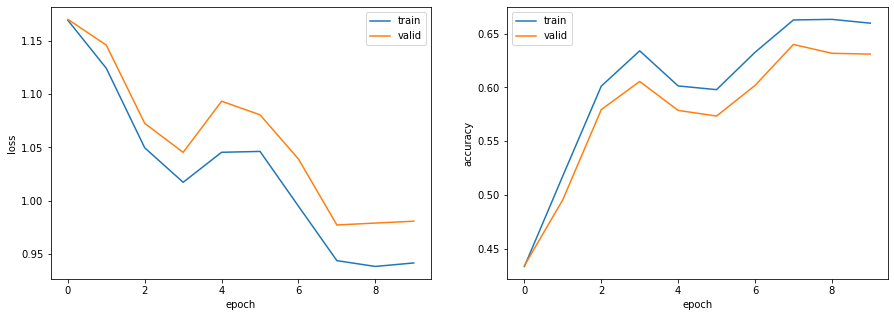

正解率（学習データ）：0.660
正解率（評価データ）：0.650


In [24]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [25]:
#85
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1634, accuracy_train: 0.4320, loss_valid: 1.1697, accuracy_valid: 0.4244, 16.6420sec
epoch: 2, loss_train: 1.1332, accuracy_train: 0.5201, loss_valid: 1.1867, accuracy_valid: 0.4895, 16.7660sec
epoch: 3, loss_train: 1.1028, accuracy_train: 0.5432, loss_valid: 1.1435, accuracy_valid: 0.5187, 16.1593sec
epoch: 4, loss_train: 1.0508, accuracy_train: 0.6018, loss_valid: 1.1057, accuracy_valid: 0.5636, 16.5220sec
epoch: 5, loss_train: 1.1369, accuracy_train: 0.5590, loss_valid: 1.1901, accuracy_valid: 0.5404, 16.0659sec
epoch: 6, loss_train: 1.0243, accuracy_train: 0.6200, loss_valid: 1.1106, accuracy_valid: 0.5838, 16.1330sec
epoch: 7, loss_train: 0.9550, accuracy_train: 0.6432, loss_valid: 1.0346, accuracy_valid: 0.6025, 16.4069sec
epoch: 8, loss_train: 0.9688, accuracy_train: 0.6409, loss_valid: 1.0576, accuracy_valid: 0.6040, 16.1417sec
epoch: 9, loss_train: 0.9592, accuracy_train: 0.6460, loss_valid: 1.0543, accuracy_valid: 0.6108, 16.8892sec
epoch: 10, loss_tra

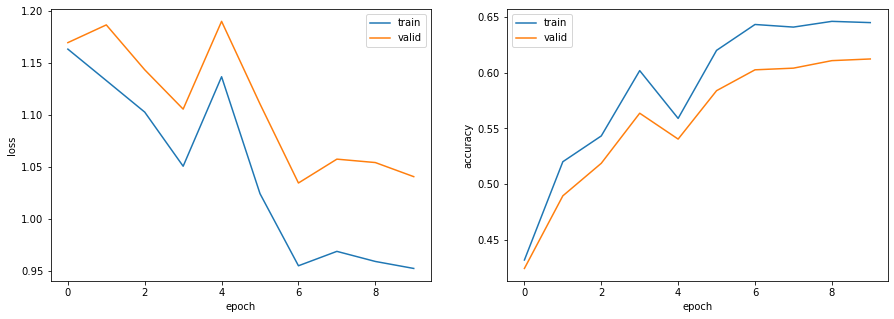

正解率（学習データ）：0.645
正解率（評価データ）：0.635


In [26]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [27]:
#86

from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)
    
  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [28]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2229, 0.3275, 0.1748, 0.2748]], grad_fn=<SoftmaxBackward>)
tensor([[0.2635, 0.2269, 0.2131, 0.2965]], grad_fn=<SoftmaxBackward>)
tensor([[0.2216, 0.2451, 0.1980, 0.3353]], grad_fn=<SoftmaxBackward>)
tensor([[0.2412, 0.2842, 0.2107, 0.2638]], grad_fn=<SoftmaxBackward>)
tensor([[0.2485, 0.2746, 0.2039, 0.2730]], grad_fn=<SoftmaxBackward>)
tensor([[0.2696, 0.2742, 0.1877, 0.2684]], grad_fn=<SoftmaxBackward>)
tensor([[0.2590, 0.2768, 0.1879, 0.2762]], grad_fn=<SoftmaxBackward>)
tensor([[0.2565, 0.2441, 0.2106, 0.2888]], grad_fn=<SoftmaxBackward>)
tensor([[0.2450, 0.2529, 0.2219, 0.2802]], grad_fn=<SoftmaxBackward>)
tensor([[0.2064, 0.2359, 0.2488, 0.3089]], grad_fn=<SoftmaxBackward>)


In [29]:
#87

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0728, accuracy_train: 0.5572, loss_valid: 1.0893, accuracy_valid: 0.5531, 7.9598sec
epoch: 2, loss_train: 0.9988, accuracy_train: 0.6246, loss_valid: 1.0329, accuracy_valid: 0.6010, 7.9088sec
epoch: 3, loss_train: 0.9244, accuracy_train: 0.6797, loss_valid: 0.9731, accuracy_valid: 0.6400, 7.8834sec
epoch: 4, loss_train: 0.8622, accuracy_train: 0.7085, loss_valid: 0.9268, accuracy_valid: 0.6654, 7.8559sec
epoch: 5, loss_train: 0.8163, accuracy_train: 0.7221, loss_valid: 0.8900, accuracy_valid: 0.6744, 7.8554sec
epoch: 6, loss_train: 0.7848, accuracy_train: 0.7367, loss_valid: 0.8710, accuracy_valid: 0.6916, 7.8573sec
epoch: 7, loss_train: 0.7621, accuracy_train: 0.7421, loss_valid: 0.8552, accuracy_valid: 0.6976, 7.8268sec
epoch: 8, loss_train: 0.7494, accuracy_train: 0.7459, loss_valid: 0.8458, accuracy_valid: 0.7028, 7.8381sec
epoch: 9, loss_train: 0.7437, accuracy_train: 0.7471, loss_valid: 0.8422, accuracy_valid: 0.7028, 7.8611sec
epoch: 10, loss_train: 0.742

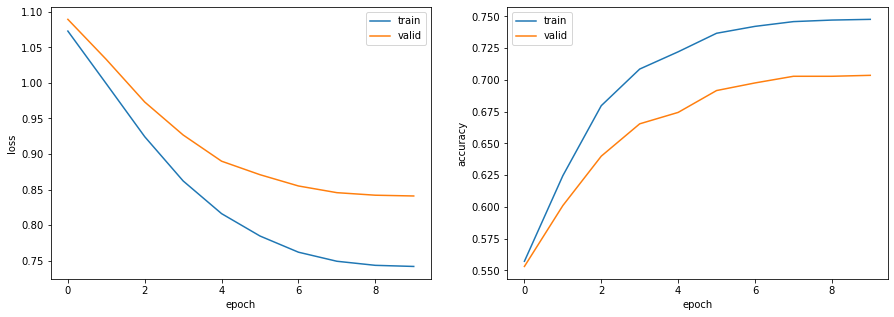

正解率（学習データ）：0.748
正解率（評価データ）：0.707


In [30]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## #88
まず #85のハイパーパラメータ探索を行う

In [31]:
!pip install optuna

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 308 kB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 22.6 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 18.7 MB/s eta 0:00:01
     |████████████████████████████████| 149 kB 42.5 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 42.4 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=162f965532b651244ab6300e3e2f4979feb3a18f550a43e1dd09ab149597e0fb
  Stored in directory: /home/jovyan/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [48]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

In [49]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden() # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(device)
    return hidden

In [50]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率を返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=num_eta_min, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    
    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
    
    # 終了時刻の記録
    e_time = time.time()
    
    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 
    
    
    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return log_train, log_valid



def display_train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率を返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=num_eta_min, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    
    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
    
    # 終了時刻の記録
    e_time = time.time()
    
    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 
    
    
    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [51]:
import optuna

def Get_Optimizer(trial, model): #optimizerの最適化関数
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD']) 
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) #学習率の初期値を変更
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    return optimizer

# デバイスの指定
device = torch.device('cuda')

def objective(trial): 
       
    # デバイスの指定
    device = torch.device('cuda')
    
    #パラメータの設定(小文字はハイパーパラメータチューニングを行う)
    VOCAB_SIZE = len(set(word2id.values())) + 1
    EMB_SIZE =300
    PADDING_IDX = len(set(word2id.values()))
    OUTPUT_SIZE = 4
    hidden_size = int(trial.suggest_discrete_uniform('hidden_size', 10, 100, 10))
    #hidden_size = 50
    num_layers = int(trial.suggest_discrete_uniform('num_layers', 2, 5, 1))
    batch_size = int(trial.suggest_discrete_uniform('batch_size', 64, 1024, 64)) #適切なバッチサイズを64-1024の間で64刻みで探す
    #num_epochs = trial.suggest_int('num_epochs', 5, 50) #適切なエポック数を探す
    num_epochs = 10
    num_eta_min = trial.suggest_loguniform('min_lr', 1e-5, 1e-1)#スケジューラの学習率の最小値
    
    
    # モデルの定義
    model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, hidden_size, num_layers, emb_weights=weights, bidirectional=True)
    
    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()
    
    # オプティマイザの定義
    #optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    optimizer = Get_Optimizer(trial,model)

    
    return train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=Padsequence(PADDING_IDX), device=device)[1][-1][0] #log_validの最後のlossを取得
    #return train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, device)[1][-3][0] #log_validの最後から3番目のlossを取得（最小値)

In [52]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=14400)

[I 2022-01-30 20:16:28,431] A new study created in memory with name: no-name-51016808-46a7-4980-9bd2-b10c2f3b660b


epoch: 1, loss_train: 1.3938, accuracy_train: 0.2098, loss_valid: 1.3872, accuracy_valid: 0.2373, 20.0498sec
epoch: 2, loss_train: 1.3848, accuracy_train: 0.2423, loss_valid: 1.3784, accuracy_valid: 0.2605, 19.9649sec
epoch: 3, loss_train: 1.3611, accuracy_train: 0.3196, loss_valid: 1.3551, accuracy_valid: 0.3368, 19.9275sec
epoch: 4, loss_train: 1.3209, accuracy_train: 0.3951, loss_valid: 1.3156, accuracy_valid: 0.3930, 19.9560sec
epoch: 5, loss_train: 1.2705, accuracy_train: 0.4099, loss_valid: 1.2664, accuracy_valid: 0.4049, 20.0746sec
epoch: 6, loss_train: 1.2228, accuracy_train: 0.4123, loss_valid: 1.2200, accuracy_valid: 0.3967, 20.0022sec
epoch: 7, loss_train: 1.1900, accuracy_train: 0.4198, loss_valid: 1.1885, accuracy_valid: 0.3997, 19.9749sec
epoch: 8, loss_train: 1.1742, accuracy_train: 0.4247, loss_valid: 1.1737, accuracy_valid: 0.4034, 19.9041sec
epoch: 9, loss_train: 1.1687, accuracy_train: 0.4244, loss_valid: 1.1686, accuracy_valid: 0.4049, 19.9187sec


[I 2022-01-30 20:19:48,240] Trial 0 finished with value: 1.1670186011020296 and parameters: {'hidden_size': 90.0, 'num_layers': 3.0, 'batch_size': 384.0, 'min_lr': 0.009582366317616893, 'optimizer': 'SGD', 'lr': 0.00013013291438730018}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.1668, accuracy_train: 0.4245, loss_valid: 1.1670, accuracy_valid: 0.4072, 19.9951sec
epoch: 1, loss_train: 1.1632, accuracy_train: 0.4110, loss_valid: 1.1656, accuracy_valid: 0.4034, 27.8341sec
epoch: 2, loss_train: 1.1611, accuracy_train: 0.4279, loss_valid: 1.1631, accuracy_valid: 0.4311, 27.7788sec
epoch: 3, loss_train: 1.2134, accuracy_train: 0.4074, loss_valid: 1.2615, accuracy_valid: 0.3982, 27.7484sec
epoch: 4, loss_train: 1.1547, accuracy_train: 0.5116, loss_valid: 1.1973, accuracy_valid: 0.4948, 27.7462sec
epoch: 5, loss_train: 1.1688, accuracy_train: 0.5281, loss_valid: 1.1863, accuracy_valid: 0.5075, 27.8821sec
epoch: 6, loss_train: 1.1763, accuracy_train: 0.5767, loss_valid: 1.2323, accuracy_valid: 0.5487, 27.5938sec
epoch: 7, loss_train: 1.5317, accuracy_train: 0.3737, loss_valid: 1.5721, accuracy_valid: 0.3892, 27.8876sec
epoch: 8, loss_train: 1.1476, accuracy_train: 0.5526, loss_valid: 1.1743, accuracy_valid: 0.5337, 27.7797sec
epoch: 9, loss_tra

[I 2022-01-30 20:24:26,341] Trial 1 finished with value: 1.2922429468839647 and parameters: {'hidden_size': 30.0, 'num_layers': 5.0, 'batch_size': 832.0, 'min_lr': 0.012418421563891356, 'optimizer': 'Adam', 'lr': 0.0006633059248505418}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.2401, accuracy_train: 0.5223, loss_valid: 1.2922, accuracy_valid: 0.4993, 27.9095sec
epoch: 1, loss_train: 1.0301, accuracy_train: 0.6162, loss_valid: 1.0570, accuracy_valid: 0.5988, 25.0913sec
epoch: 2, loss_train: 1.0765, accuracy_train: 0.5845, loss_valid: 1.0974, accuracy_valid: 0.5509, 25.2260sec
epoch: 3, loss_train: 1.1649, accuracy_train: 0.3964, loss_valid: 1.1719, accuracy_valid: 0.3960, 25.0666sec
epoch: 4, loss_train: 1.1393, accuracy_train: 0.4999, loss_valid: 1.1412, accuracy_valid: 0.4850, 25.2038sec
epoch: 5, loss_train: 1.1856, accuracy_train: 0.4266, loss_valid: 1.2066, accuracy_valid: 0.4214, 25.1101sec
epoch: 6, loss_train: 1.1751, accuracy_train: 0.3946, loss_valid: 1.1819, accuracy_valid: 0.3937, 25.0916sec
epoch: 7, loss_train: 1.6230, accuracy_train: 0.2158, loss_valid: 1.6674, accuracy_valid: 0.1961, 25.3143sec
epoch: 8, loss_train: 1.2415, accuracy_train: 0.4163, loss_valid: 1.2513, accuracy_valid: 0.4049, 25.1244sec
epoch: 9, loss_tra

[I 2022-01-30 20:28:37,898] Trial 2 finished with value: 1.228107738682253 and parameters: {'hidden_size': 50.0, 'num_layers': 4.0, 'batch_size': 128.0, 'min_lr': 0.022773643002911275, 'optimizer': 'Adam', 'lr': 0.004139869635237494}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.2459, accuracy_train: 0.4070, loss_valid: 1.2281, accuracy_valid: 0.4019, 25.1770sec
epoch: 1, loss_train: 1.2649, accuracy_train: 0.4246, loss_valid: 1.2637, accuracy_valid: 0.4244, 27.7417sec
epoch: 2, loss_train: 1.2101, accuracy_train: 0.4214, loss_valid: 1.2089, accuracy_valid: 0.4319, 27.7483sec
epoch: 3, loss_train: 1.1870, accuracy_train: 0.4203, loss_valid: 1.1857, accuracy_valid: 0.4281, 27.8209sec
epoch: 4, loss_train: 1.1772, accuracy_train: 0.4207, loss_valid: 1.1759, accuracy_valid: 0.4274, 27.7059sec
epoch: 5, loss_train: 1.1729, accuracy_train: 0.4207, loss_valid: 1.1716, accuracy_valid: 0.4304, 27.8148sec
epoch: 6, loss_train: 1.1707, accuracy_train: 0.4209, loss_valid: 1.1694, accuracy_valid: 0.4296, 27.7452sec
epoch: 7, loss_train: 1.1696, accuracy_train: 0.4200, loss_valid: 1.1683, accuracy_valid: 0.4274, 27.5216sec
epoch: 8, loss_train: 1.1690, accuracy_train: 0.4209, loss_valid: 1.1677, accuracy_valid: 0.4281, 27.8598sec
epoch: 9, loss_tra

[I 2022-01-30 20:33:15,320] Trial 3 finished with value: 1.1674573120778193 and parameters: {'hidden_size': 80.0, 'num_layers': 5.0, 'batch_size': 1024.0, 'min_lr': 2.4240921484684552e-05, 'optimizer': 'SGD', 'lr': 0.01131922354546442}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.1687, accuracy_train: 0.4208, loss_valid: 1.1675, accuracy_valid: 0.4266, 27.7982sec
epoch: 1, loss_train: 1.3269, accuracy_train: 0.3693, loss_valid: 1.3276, accuracy_valid: 0.3735, 15.8640sec
epoch: 2, loss_train: 1.2160, accuracy_train: 0.4027, loss_valid: 1.2169, accuracy_valid: 0.4019, 15.8428sec
epoch: 3, loss_train: 1.1678, accuracy_train: 0.4223, loss_valid: 1.1667, accuracy_valid: 0.4222, 15.8502sec
epoch: 4, loss_train: 1.1779, accuracy_train: 0.4062, loss_valid: 1.1860, accuracy_valid: 0.4132, 15.8483sec
epoch: 5, loss_train: 1.2319, accuracy_train: 0.3915, loss_valid: 1.2507, accuracy_valid: 0.3915, 15.8518sec
epoch: 6, loss_train: 1.1224, accuracy_train: 0.5446, loss_valid: 1.1518, accuracy_valid: 0.5210, 15.8323sec
epoch: 7, loss_train: 1.1684, accuracy_train: 0.5408, loss_valid: 1.2154, accuracy_valid: 0.5187, 15.8221sec
epoch: 8, loss_train: 1.1549, accuracy_train: 0.5768, loss_valid: 1.2300, accuracy_valid: 0.5404, 15.9102sec
epoch: 9, loss_tra

[I 2022-01-30 20:35:53,874] Trial 4 finished with value: 1.1974503598594202 and parameters: {'hidden_size': 20.0, 'num_layers': 2.0, 'batch_size': 256.0, 'min_lr': 0.0032793060443160305, 'optimizer': 'Adam', 'lr': 7.74626630858388e-05}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.1340, accuracy_train: 0.5857, loss_valid: 1.1975, accuracy_valid: 0.5599, 15.8477sec
epoch: 1, loss_train: 1.3267, accuracy_train: 0.3837, loss_valid: 1.3364, accuracy_valid: 0.3907, 15.8184sec
epoch: 2, loss_train: 1.2946, accuracy_train: 0.3983, loss_valid: 1.3043, accuracy_valid: 0.4094, 15.8414sec
epoch: 3, loss_train: 1.2720, accuracy_train: 0.4031, loss_valid: 1.2816, accuracy_valid: 0.4154, 15.8122sec
epoch: 4, loss_train: 1.2564, accuracy_train: 0.4043, loss_valid: 1.2659, accuracy_valid: 0.4169, 15.9039sec
epoch: 5, loss_train: 1.2457, accuracy_train: 0.4043, loss_valid: 1.2551, accuracy_valid: 0.4154, 15.9198sec
epoch: 6, loss_train: 1.2387, accuracy_train: 0.4044, loss_valid: 1.2480, accuracy_valid: 0.4132, 15.7919sec
epoch: 7, loss_train: 1.2342, accuracy_train: 0.4053, loss_valid: 1.2435, accuracy_valid: 0.4139, 15.9527sec
epoch: 8, loss_train: 1.2317, accuracy_train: 0.4061, loss_valid: 1.2409, accuracy_valid: 0.4132, 15.8490sec
epoch: 9, loss_tra

[I 2022-01-30 20:38:32,382] Trial 5 finished with value: 1.2390197419567022 and parameters: {'hidden_size': 10.0, 'num_layers': 2.0, 'batch_size': 832.0, 'min_lr': 0.00028275919755516574, 'optimizer': 'SGD', 'lr': 0.010992155559429501}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.2298, accuracy_train: 0.4068, loss_valid: 1.2390, accuracy_valid: 0.4117, 15.7092sec
epoch: 1, loss_train: 1.4279, accuracy_train: 0.1471, loss_valid: 1.4286, accuracy_valid: 0.1557, 15.9041sec
epoch: 2, loss_train: 1.4174, accuracy_train: 0.1700, loss_valid: 1.4183, accuracy_valid: 0.1751, 16.0307sec
epoch: 3, loss_train: 1.3813, accuracy_train: 0.2762, loss_valid: 1.3826, accuracy_valid: 0.2829, 15.9242sec
epoch: 4, loss_train: 1.3215, accuracy_train: 0.4053, loss_valid: 1.3236, accuracy_valid: 0.4034, 15.8937sec
epoch: 5, loss_train: 1.2549, accuracy_train: 0.4202, loss_valid: 1.2576, accuracy_valid: 0.4229, 15.7166sec
epoch: 6, loss_train: 1.2034, accuracy_train: 0.4199, loss_valid: 1.2060, accuracy_valid: 0.4184, 15.9548sec
epoch: 7, loss_train: 1.1773, accuracy_train: 0.4200, loss_valid: 1.1792, accuracy_valid: 0.4259, 15.8157sec
epoch: 8, loss_train: 1.1685, accuracy_train: 0.4208, loss_valid: 1.1698, accuracy_valid: 0.4207, 15.7988sec
epoch: 9, loss_tra

[I 2022-01-30 20:41:11,109] Trial 6 finished with value: 1.1657964696962677 and parameters: {'hidden_size': 90.0, 'num_layers': 2.0, 'batch_size': 1024.0, 'min_lr': 0.04305117790145214, 'optimizer': 'SGD', 'lr': 1.6504128929549728e-05}. Best is trial 6 with value: 1.1657964696962677.


epoch: 10, loss_train: 1.1651, accuracy_train: 0.4136, loss_valid: 1.1658, accuracy_valid: 0.4192, 15.8063sec
epoch: 1, loss_train: 1.3960, accuracy_train: 0.2012, loss_valid: 1.3996, accuracy_valid: 0.1729, 24.2092sec
epoch: 2, loss_train: 1.3911, accuracy_train: 0.2210, loss_valid: 1.3948, accuracy_valid: 0.1841, 24.3362sec
epoch: 3, loss_train: 1.3865, accuracy_train: 0.2390, loss_valid: 1.3903, accuracy_valid: 0.2066, 24.3379sec
epoch: 4, loss_train: 1.3822, accuracy_train: 0.2579, loss_valid: 1.3861, accuracy_valid: 0.2208, 24.2834sec
epoch: 5, loss_train: 1.3784, accuracy_train: 0.2710, loss_valid: 1.3824, accuracy_valid: 0.2410, 24.2952sec
epoch: 6, loss_train: 1.3750, accuracy_train: 0.2851, loss_valid: 1.3791, accuracy_valid: 0.2567, 24.3801sec
epoch: 7, loss_train: 1.3720, accuracy_train: 0.2991, loss_valid: 1.3761, accuracy_valid: 0.2657, 24.2359sec
epoch: 8, loss_train: 1.3694, accuracy_train: 0.3094, loss_valid: 1.3736, accuracy_valid: 0.2769, 24.3224sec
epoch: 9, loss_tra

[I 2022-01-30 20:45:14,123] Trial 7 finished with value: 1.3691189713820726 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 256.0, 'min_lr': 4.796703483477973e-05, 'optimizer': 'SGD', 'lr': 9.618087886858199e-05}. Best is trial 6 with value: 1.1657964696962677.


epoch: 10, loss_train: 1.3648, accuracy_train: 0.3258, loss_valid: 1.3691, accuracy_valid: 0.2979, 24.3414sec
epoch: 1, loss_train: 6.9911, accuracy_train: 0.3790, loss_valid: 7.3350, accuracy_valid: 0.3466, 28.0645sec
epoch: 2, loss_train: 2.6110, accuracy_train: 0.3663, loss_valid: 3.0988, accuracy_valid: 0.3466, 27.9914sec
epoch: 3, loss_train: 5.0430, accuracy_train: 0.3911, loss_valid: 5.3964, accuracy_valid: 0.3615, 28.1530sec
epoch: 4, loss_train: 2.5546, accuracy_train: 0.3085, loss_valid: 2.8887, accuracy_valid: 0.3001, 28.0970sec
epoch: 5, loss_train: 2.5082, accuracy_train: 0.3913, loss_valid: 2.6948, accuracy_valid: 0.3855, 28.1682sec
epoch: 6, loss_train: 2.1333, accuracy_train: 0.3926, loss_valid: 2.3648, accuracy_valid: 0.3885, 28.3312sec
epoch: 7, loss_train: 1.8705, accuracy_train: 0.3911, loss_valid: 2.1740, accuracy_valid: 0.3840, 28.0563sec
epoch: 8, loss_train: 1.7346, accuracy_train: 0.3907, loss_valid: 2.0589, accuracy_valid: 0.3593, 28.1853sec
epoch: 9, loss_tra

[I 2022-01-30 20:49:55,361] Trial 8 finished with value: 2.0410245533443185 and parameters: {'hidden_size': 40.0, 'num_layers': 5.0, 'batch_size': 448.0, 'min_lr': 4.790282609520423e-05, 'optimizer': 'RMSprop', 'lr': 0.058667278277811624}. Best is trial 6 with value: 1.1657964696962677.


epoch: 10, loss_train: 1.7176, accuracy_train: 0.4053, loss_valid: 2.0410, accuracy_valid: 0.3847, 28.1049sec
epoch: 1, loss_train: 1.3977, accuracy_train: 0.2711, loss_valid: 1.4036, accuracy_valid: 0.2448, 24.0043sec
epoch: 2, loss_train: 1.3974, accuracy_train: 0.2721, loss_valid: 1.4033, accuracy_valid: 0.2448, 23.8879sec
epoch: 3, loss_train: 1.3971, accuracy_train: 0.2736, loss_valid: 1.4030, accuracy_valid: 0.2485, 23.9553sec
epoch: 4, loss_train: 1.3968, accuracy_train: 0.2742, loss_valid: 1.4028, accuracy_valid: 0.2500, 23.9336sec
epoch: 5, loss_train: 1.3965, accuracy_train: 0.2748, loss_valid: 1.4025, accuracy_valid: 0.2515, 24.0381sec
epoch: 6, loss_train: 1.3963, accuracy_train: 0.2748, loss_valid: 1.4022, accuracy_valid: 0.2545, 23.9136sec
epoch: 7, loss_train: 1.3960, accuracy_train: 0.2754, loss_valid: 1.4020, accuracy_valid: 0.2545, 23.9459sec
epoch: 8, loss_train: 1.3958, accuracy_train: 0.2759, loss_valid: 1.4017, accuracy_valid: 0.2545, 24.0302sec
epoch: 9, loss_tra

[I 2022-01-30 20:53:54,845] Trial 9 finished with value: 1.4012742790276418 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 640.0, 'min_lr': 1.1032115691574387e-05, 'optimizer': 'SGD', 'lr': 1.3653296186450255e-05}. Best is trial 6 with value: 1.1657964696962677.


epoch: 10, loss_train: 1.3953, accuracy_train: 0.2763, loss_valid: 1.4013, accuracy_valid: 0.2567, 23.9689sec
epoch: 1, loss_train: 1.3075, accuracy_train: 0.3984, loss_valid: 1.3041, accuracy_valid: 0.3915, 19.8458sec
epoch: 2, loss_train: 1.7962, accuracy_train: 0.1130, loss_valid: 1.8043, accuracy_valid: 0.1078, 19.9541sec
epoch: 3, loss_train: 2.1016, accuracy_train: 0.3011, loss_valid: 2.1826, accuracy_valid: 0.2934, 19.6893sec


[I 2022-01-30 20:55:14,080] Trial 10 finished with value: 7.317129891740782 and parameters: {'hidden_size': 100.0, 'num_layers': 3.0, 'batch_size': 1024.0, 'min_lr': 0.09771458494424784, 'optimizer': 'RMSprop', 'lr': 1.2221289376967635e-05}. Best is trial 6 with value: 1.1657964696962677.


epoch: 4, loss_train: 7.5043, accuracy_train: 0.3204, loss_valid: 7.3171, accuracy_valid: 0.3226, 19.7089sec
epoch: 1, loss_train: 1.3671, accuracy_train: 0.3595, loss_valid: 1.3691, accuracy_valid: 0.3555, 19.7792sec
epoch: 2, loss_train: 1.3334, accuracy_train: 0.4137, loss_valid: 1.3352, accuracy_valid: 0.4094, 19.8333sec
epoch: 3, loss_train: 1.2489, accuracy_train: 0.4252, loss_valid: 1.2502, accuracy_valid: 0.4207, 19.9542sec
epoch: 4, loss_train: 1.1828, accuracy_train: 0.4282, loss_valid: 1.1832, accuracy_valid: 0.4229, 19.9006sec
epoch: 5, loss_train: 1.1682, accuracy_train: 0.4267, loss_valid: 1.1679, accuracy_valid: 0.4237, 19.7072sec
epoch: 6, loss_train: 1.1680, accuracy_train: 0.4273, loss_valid: 1.1676, accuracy_valid: 0.4222, 19.9376sec
epoch: 7, loss_train: 1.1658, accuracy_train: 0.4262, loss_valid: 1.1650, accuracy_valid: 0.4237, 19.9079sec
epoch: 8, loss_train: 1.1660, accuracy_train: 0.4189, loss_valid: 1.1651, accuracy_valid: 0.4334, 19.8532sec
epoch: 9, loss_trai

[I 2022-01-30 20:58:32,721] Trial 11 finished with value: 1.1647830112073236 and parameters: {'hidden_size': 100.0, 'num_layers': 3.0, 'batch_size': 512.0, 'min_lr': 0.09729229268058791, 'optimizer': 'SGD', 'lr': 0.00012849810312665557}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.1653, accuracy_train: 0.4305, loss_valid: 1.1648, accuracy_valid: 0.4356, 19.7892sec
epoch: 1, loss_train: 1.3978, accuracy_train: 0.2719, loss_valid: 1.4012, accuracy_valid: 0.2522, 16.0407sec
epoch: 2, loss_train: 1.3708, accuracy_train: 0.3326, loss_valid: 1.3745, accuracy_valid: 0.3166, 15.8566sec
epoch: 3, loss_train: 1.2975, accuracy_train: 0.3816, loss_valid: 1.3018, accuracy_valid: 0.3840, 15.9731sec
epoch: 4, loss_train: 1.2104, accuracy_train: 0.3992, loss_valid: 1.2146, accuracy_valid: 0.3772, 16.0196sec
epoch: 5, loss_train: 1.1728, accuracy_train: 0.4063, loss_valid: 1.1757, accuracy_valid: 0.3892, 15.9917sec
epoch: 6, loss_train: 1.1680, accuracy_train: 0.4020, loss_valid: 1.1701, accuracy_valid: 0.3900, 15.8821sec
epoch: 7, loss_train: 1.1669, accuracy_train: 0.4073, loss_valid: 1.1689, accuracy_valid: 0.3885, 16.0282sec
epoch: 8, loss_train: 1.1674, accuracy_train: 0.3943, loss_valid: 1.1691, accuracy_valid: 0.3757, 15.8969sec
epoch: 9, loss_tra

[I 2022-01-30 21:01:12,420] Trial 12 finished with value: 1.169192876956777 and parameters: {'hidden_size': 80.0, 'num_layers': 2.0, 'batch_size': 640.0, 'min_lr': 0.09623484373505821, 'optimizer': 'SGD', 'lr': 0.0003881941457810236}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.1672, accuracy_train: 0.4014, loss_valid: 1.1692, accuracy_valid: 0.3743, 15.9510sec
epoch: 1, loss_train: 1.3709, accuracy_train: 0.3221, loss_valid: 1.3706, accuracy_valid: 0.3241, 19.8808sec
epoch: 2, loss_train: 1.3702, accuracy_train: 0.3245, loss_valid: 1.3699, accuracy_valid: 0.3249, 19.6799sec
epoch: 3, loss_train: 1.3687, accuracy_train: 0.3302, loss_valid: 1.3684, accuracy_valid: 0.3308, 19.7804sec
epoch: 4, loss_train: 1.3661, accuracy_train: 0.3415, loss_valid: 1.3657, accuracy_valid: 0.3391, 19.7468sec
epoch: 5, loss_train: 1.3620, accuracy_train: 0.3537, loss_valid: 1.3616, accuracy_valid: 0.3481, 19.7182sec
epoch: 6, loss_train: 1.3565, accuracy_train: 0.3697, loss_valid: 1.3561, accuracy_valid: 0.3615, 19.8226sec
epoch: 7, loss_train: 1.3497, accuracy_train: 0.3827, loss_valid: 1.3493, accuracy_valid: 0.3780, 19.7845sec
epoch: 8, loss_train: 1.3420, accuracy_train: 0.3940, loss_valid: 1.3415, accuracy_valid: 0.3862, 19.6960sec
epoch: 9, loss_tra

[I 2022-01-30 21:04:30,170] Trial 13 finished with value: 1.3245431232059788 and parameters: {'hidden_size': 100.0, 'num_layers': 3.0, 'batch_size': 768.0, 'min_lr': 0.0009398449117989522, 'optimizer': 'SGD', 'lr': 3.6895937331460155e-05}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.3251, accuracy_train: 0.4032, loss_valid: 1.3245, accuracy_valid: 0.4109, 19.8104sec
epoch: 1, loss_train: 1.3823, accuracy_train: 0.2873, loss_valid: 1.3811, accuracy_valid: 0.2799, 16.0227sec
epoch: 2, loss_train: 1.3688, accuracy_train: 0.3307, loss_valid: 1.3676, accuracy_valid: 0.3278, 15.9798sec
epoch: 3, loss_train: 1.3306, accuracy_train: 0.3973, loss_valid: 1.3295, accuracy_valid: 0.3982, 15.8398sec
epoch: 4, loss_train: 1.2702, accuracy_train: 0.4076, loss_valid: 1.2691, accuracy_valid: 0.4049, 16.1646sec
epoch: 5, loss_train: 1.2093, accuracy_train: 0.4091, loss_valid: 1.2084, accuracy_valid: 0.4049, 16.0748sec
epoch: 6, loss_train: 1.1762, accuracy_train: 0.4118, loss_valid: 1.1754, accuracy_valid: 0.4049, 16.0621sec
epoch: 7, loss_train: 1.1676, accuracy_train: 0.4117, loss_valid: 1.1667, accuracy_valid: 0.4042, 16.0491sec
epoch: 8, loss_train: 1.1666, accuracy_train: 0.4087, loss_valid: 1.1657, accuracy_valid: 0.4072, 16.0638sec
epoch: 9, loss_tra

[I 2022-01-30 21:07:10,639] Trial 14 finished with value: 1.1651050950774176 and parameters: {'hidden_size': 80.0, 'num_layers': 2.0, 'batch_size': 512.0, 'min_lr': 0.040733571544799965, 'optimizer': 'SGD', 'lr': 0.00032401117122214375}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.1660, accuracy_train: 0.4117, loss_valid: 1.1651, accuracy_valid: 0.4019, 15.9776sec
epoch: 1, loss_train: 1.1768, accuracy_train: 0.3913, loss_valid: 1.1765, accuracy_valid: 0.3937, 20.0095sec
epoch: 2, loss_train: 1.1845, accuracy_train: 0.3604, loss_valid: 1.1795, accuracy_valid: 0.3698, 19.8958sec
epoch: 3, loss_train: 1.4131, accuracy_train: 0.3458, loss_valid: 1.3802, accuracy_valid: 0.3503, 19.8473sec
epoch: 4, loss_train: 1.1624, accuracy_train: 0.4239, loss_valid: 1.1686, accuracy_valid: 0.4139, 20.0423sec
epoch: 5, loss_train: 1.1848, accuracy_train: 0.3990, loss_valid: 1.1893, accuracy_valid: 0.3862, 19.9751sec
epoch: 6, loss_train: 1.1876, accuracy_train: 0.4232, loss_valid: 1.1890, accuracy_valid: 0.4222, 19.9098sec
epoch: 7, loss_train: 1.1683, accuracy_train: 0.3902, loss_valid: 1.1722, accuracy_valid: 0.3862, 19.8468sec
epoch: 8, loss_train: 1.1371, accuracy_train: 0.5109, loss_valid: 1.1495, accuracy_valid: 0.4820, 19.9293sec
epoch: 9, loss_tra

[I 2022-01-30 21:10:29,940] Trial 15 finished with value: 1.2628870558685172 and parameters: {'hidden_size': 70.0, 'num_layers': 3.0, 'batch_size': 512.0, 'min_lr': 0.005158632055726088, 'optimizer': 'RMSprop', 'lr': 0.0018041288034376848}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.2677, accuracy_train: 0.4169, loss_valid: 1.2629, accuracy_valid: 0.4184, 19.8688sec
epoch: 1, loss_train: 1.3507, accuracy_train: 0.3798, loss_valid: 1.3476, accuracy_valid: 0.3743, 16.1604sec
epoch: 2, loss_train: 1.3460, accuracy_train: 0.3873, loss_valid: 1.3430, accuracy_valid: 0.3757, 16.1941sec
epoch: 3, loss_train: 1.3390, accuracy_train: 0.3952, loss_valid: 1.3361, accuracy_valid: 0.3862, 16.1671sec
epoch: 4, loss_train: 1.3288, accuracy_train: 0.4041, loss_valid: 1.3260, accuracy_valid: 0.3967, 16.2708sec
epoch: 5, loss_train: 1.3151, accuracy_train: 0.4115, loss_valid: 1.3126, accuracy_valid: 0.4102, 16.1544sec
epoch: 6, loss_train: 1.2985, accuracy_train: 0.4180, loss_valid: 1.2962, accuracy_valid: 0.4192, 16.2920sec
epoch: 7, loss_train: 1.2800, accuracy_train: 0.4191, loss_valid: 1.2781, accuracy_valid: 0.4289, 16.2170sec
epoch: 8, loss_train: 1.2612, accuracy_train: 0.4196, loss_valid: 1.2594, accuracy_valid: 0.4311, 16.0595sec
epoch: 9, loss_tra

[I 2022-01-30 21:13:11,823] Trial 16 finished with value: 1.2262053637358243 and parameters: {'hidden_size': 80.0, 'num_layers': 2.0, 'batch_size': 320.0, 'min_lr': 0.0024142168897395566, 'optimizer': 'SGD', 'lr': 0.0002376811713142408}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.2277, accuracy_train: 0.4166, loss_valid: 1.2262, accuracy_valid: 0.4289, 16.2020sec
epoch: 1, loss_train: 1.3916, accuracy_train: 0.2313, loss_valid: 1.3960, accuracy_valid: 0.2410, 19.7923sec
epoch: 2, loss_train: 1.3628, accuracy_train: 0.3488, loss_valid: 1.3676, accuracy_valid: 0.3353, 19.8522sec
epoch: 3, loss_train: 1.3129, accuracy_train: 0.4098, loss_valid: 1.3182, accuracy_valid: 0.3907, 19.8283sec
epoch: 4, loss_train: 1.2487, accuracy_train: 0.4115, loss_valid: 1.2546, accuracy_valid: 0.4079, 19.8815sec
epoch: 5, loss_train: 1.1952, accuracy_train: 0.4142, loss_valid: 1.2009, accuracy_valid: 0.4079, 19.8166sec
epoch: 6, loss_train: 1.1712, accuracy_train: 0.4141, loss_valid: 1.1762, accuracy_valid: 0.4057, 19.7388sec
epoch: 7, loss_train: 1.1651, accuracy_train: 0.4145, loss_valid: 1.1697, accuracy_valid: 0.4064, 19.8028sec
epoch: 8, loss_train: 1.1645, accuracy_train: 0.4140, loss_valid: 1.1691, accuracy_valid: 0.4109, 19.8359sec
epoch: 9, loss_tra

[I 2022-01-30 21:16:29,938] Trial 17 finished with value: 1.1692487224044201 and parameters: {'hidden_size': 100.0, 'num_layers': 3.0, 'batch_size': 640.0, 'min_lr': 0.03727598128768002, 'optimizer': 'SGD', 'lr': 0.0013947622949880873}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.1646, accuracy_train: 0.4106, loss_valid: 1.1692, accuracy_valid: 0.3960, 19.7500sec
epoch: 1, loss_train: 1.2363, accuracy_train: 0.4000, loss_valid: 1.2740, accuracy_valid: 0.3975, 15.8987sec
epoch: 2, loss_train: 1.1609, accuracy_train: 0.4921, loss_valid: 1.1991, accuracy_valid: 0.4753, 16.0711sec
epoch: 3, loss_train: 1.1120, accuracy_train: 0.5465, loss_valid: 1.1499, accuracy_valid: 0.5217, 16.0981sec
epoch: 4, loss_train: 1.0552, accuracy_train: 0.6103, loss_valid: 1.1020, accuracy_valid: 0.5831, 16.1826sec
epoch: 5, loss_train: 1.0791, accuracy_train: 0.6111, loss_valid: 1.1339, accuracy_valid: 0.5801, 16.0755sec
epoch: 6, loss_train: 1.1029, accuracy_train: 0.5578, loss_valid: 1.1608, accuracy_valid: 0.5337, 16.0882sec
epoch: 7, loss_train: 1.0041, accuracy_train: 0.6115, loss_valid: 1.0570, accuracy_valid: 0.5786, 16.1080sec
epoch: 8, loss_train: 1.0190, accuracy_train: 0.6013, loss_valid: 1.0970, accuracy_valid: 0.5659, 15.9405sec
epoch: 9, loss_tra

[I 2022-01-30 21:19:10,443] Trial 18 finished with value: 1.1269427166392882 and parameters: {'hidden_size': 70.0, 'num_layers': 2.0, 'batch_size': 512.0, 'min_lr': 0.0005855979649919509, 'optimizer': 'RMSprop', 'lr': 0.000290621657961563}. Best is trial 18 with value: 1.1269427166392882.


epoch: 10, loss_train: 1.0181, accuracy_train: 0.5972, loss_valid: 1.1269, accuracy_valid: 0.5434, 15.9129sec
epoch: 1, loss_train: 1.1653, accuracy_train: 0.4225, loss_valid: 1.1699, accuracy_valid: 0.4162, 20.7608sec
epoch: 2, loss_train: 1.1742, accuracy_train: 0.3955, loss_valid: 1.1834, accuracy_valid: 0.3982, 20.6963sec
epoch: 3, loss_train: 1.1899, accuracy_train: 0.4025, loss_valid: 1.2150, accuracy_valid: 0.4004, 20.7337sec
epoch: 4, loss_train: 1.1187, accuracy_train: 0.5139, loss_valid: 1.1435, accuracy_valid: 0.5015, 20.6790sec
epoch: 5, loss_train: 0.9923, accuracy_train: 0.6291, loss_valid: 1.0222, accuracy_valid: 0.6055, 20.7266sec
epoch: 6, loss_train: 1.0782, accuracy_train: 0.5652, loss_valid: 1.1320, accuracy_valid: 0.5374, 20.7175sec
epoch: 7, loss_train: 0.9847, accuracy_train: 0.6359, loss_valid: 1.0477, accuracy_valid: 0.6078, 20.7664sec
epoch: 8, loss_train: 0.9376, accuracy_train: 0.6585, loss_valid: 1.0123, accuracy_valid: 0.6280, 20.7093sec
epoch: 9, loss_tra

[I 2022-01-30 21:22:37,654] Trial 19 finished with value: 1.0049202118437002 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 64.0, 'min_lr': 0.0003142913328109574, 'optimizer': 'RMSprop', 'lr': 4.7847959254919e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9117, accuracy_train: 0.6639, loss_valid: 1.0049, accuracy_valid: 0.6190, 20.6898sec
epoch: 1, loss_train: 1.1671, accuracy_train: 0.3991, loss_valid: 1.1696, accuracy_valid: 0.3952, 25.0474sec
epoch: 2, loss_train: 1.1725, accuracy_train: 0.4150, loss_valid: 1.1883, accuracy_valid: 0.4251, 25.1130sec
epoch: 3, loss_train: 1.1760, accuracy_train: 0.4476, loss_valid: 1.2106, accuracy_valid: 0.4506, 25.0681sec
epoch: 4, loss_train: 1.1488, accuracy_train: 0.5053, loss_valid: 1.1769, accuracy_valid: 0.5082, 25.1320sec
epoch: 5, loss_train: 1.1669, accuracy_train: 0.5060, loss_valid: 1.2051, accuracy_valid: 0.5015, 25.1283sec
epoch: 6, loss_train: 1.2521, accuracy_train: 0.4991, loss_valid: 1.2857, accuracy_valid: 0.4963, 25.1285sec
epoch: 7, loss_train: 1.1034, accuracy_train: 0.5614, loss_valid: 1.1303, accuracy_valid: 0.5561, 25.0827sec
epoch: 8, loss_train: 1.1013, accuracy_train: 0.5724, loss_valid: 1.1506, accuracy_valid: 0.5584, 25.0859sec
epoch: 9, loss_tra

[I 2022-01-30 21:26:48,625] Trial 20 finished with value: 1.0687050428241491 and parameters: {'hidden_size': 50.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.0003289924837629117, 'optimizer': 'RMSprop', 'lr': 4.1696240585307503e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9992, accuracy_train: 0.6176, loss_valid: 1.0687, accuracy_valid: 0.5966, 25.0945sec
epoch: 1, loss_train: 1.1618, accuracy_train: 0.4162, loss_valid: 1.1605, accuracy_valid: 0.4341, 25.0640sec
epoch: 2, loss_train: 1.1610, accuracy_train: 0.4339, loss_valid: 1.1705, accuracy_valid: 0.4177, 25.0381sec
epoch: 3, loss_train: 1.1510, accuracy_train: 0.4655, loss_valid: 1.1785, accuracy_valid: 0.4499, 25.0727sec
epoch: 4, loss_train: 1.0650, accuracy_train: 0.5728, loss_valid: 1.0876, accuracy_valid: 0.5599, 25.1020sec
epoch: 5, loss_train: 1.0052, accuracy_train: 0.6227, loss_valid: 1.0321, accuracy_valid: 0.6055, 25.0739sec
epoch: 6, loss_train: 1.0485, accuracy_train: 0.6047, loss_valid: 1.1211, accuracy_valid: 0.5734, 25.1117sec
epoch: 7, loss_train: 1.2256, accuracy_train: 0.5244, loss_valid: 1.2845, accuracy_valid: 0.5150, 25.0800sec
epoch: 8, loss_train: 1.1219, accuracy_train: 0.5723, loss_valid: 1.1820, accuracy_valid: 0.5576, 25.0871sec
epoch: 9, loss_tra

[I 2022-01-30 21:30:59,418] Trial 21 finished with value: 1.016098532401873 and parameters: {'hidden_size': 50.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.0002963047609338001, 'optimizer': 'RMSprop', 'lr': 3.304788445638084e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9609, accuracy_train: 0.6469, loss_valid: 1.0161, accuracy_valid: 0.6145, 25.0836sec
epoch: 1, loss_train: 1.1617, accuracy_train: 0.4363, loss_valid: 1.1651, accuracy_valid: 0.4169, 25.0486sec
epoch: 2, loss_train: 1.1719, accuracy_train: 0.4098, loss_valid: 1.1877, accuracy_valid: 0.3990, 25.0976sec
epoch: 3, loss_train: 1.1871, accuracy_train: 0.4269, loss_valid: 1.2230, accuracy_valid: 0.4169, 25.0555sec
epoch: 4, loss_train: 1.1214, accuracy_train: 0.5106, loss_valid: 1.1521, accuracy_valid: 0.4895, 25.0889sec
epoch: 5, loss_train: 1.0778, accuracy_train: 0.5558, loss_valid: 1.1170, accuracy_valid: 0.5344, 25.0315sec
epoch: 6, loss_train: 1.0868, accuracy_train: 0.5488, loss_valid: 1.1274, accuracy_valid: 0.5292, 25.1197sec
epoch: 7, loss_train: 1.0350, accuracy_train: 0.5831, loss_valid: 1.0691, accuracy_valid: 0.5659, 25.0289sec
epoch: 8, loss_train: 0.9952, accuracy_train: 0.6111, loss_valid: 1.0335, accuracy_valid: 0.5966, 25.0899sec
epoch: 9, loss_tra

[I 2022-01-30 21:35:10,052] Trial 22 finished with value: 1.0487954591841486 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.0002497391763981589, 'optimizer': 'RMSprop', 'lr': 3.648403195729291e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9798, accuracy_train: 0.6218, loss_valid: 1.0488, accuracy_valid: 0.5921, 25.0234sec
epoch: 1, loss_train: 1.1672, accuracy_train: 0.4091, loss_valid: 1.1674, accuracy_valid: 0.4064, 25.1223sec
epoch: 2, loss_train: 1.1652, accuracy_train: 0.4019, loss_valid: 1.1665, accuracy_valid: 0.3907, 25.0529sec
epoch: 3, loss_train: 1.1661, accuracy_train: 0.4389, loss_valid: 1.1850, accuracy_valid: 0.4491, 25.1860sec
epoch: 4, loss_train: 1.1857, accuracy_train: 0.4233, loss_valid: 1.2168, accuracy_valid: 0.4214, 25.1368sec
epoch: 5, loss_train: 1.1883, accuracy_train: 0.4467, loss_valid: 1.2052, accuracy_valid: 0.4446, 25.1387sec
epoch: 6, loss_train: 1.1729, accuracy_train: 0.4732, loss_valid: 1.1902, accuracy_valid: 0.4618, 25.1042sec
epoch: 7, loss_train: 1.1843, accuracy_train: 0.4744, loss_valid: 1.2055, accuracy_valid: 0.4573, 25.1103sec
epoch: 8, loss_train: 1.0998, accuracy_train: 0.5402, loss_valid: 1.1267, accuracy_valid: 0.5210, 25.0506sec
epoch: 9, loss_tra

[I 2022-01-30 21:39:21,156] Trial 23 finished with value: 1.2195458532294292 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 128.0, 'min_lr': 0.00013402663018473803, 'optimizer': 'RMSprop', 'lr': 3.8374012931029676e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.1648, accuracy_train: 0.5293, loss_valid: 1.2195, accuracy_valid: 0.5112, 25.1307sec
epoch: 1, loss_train: 1.1647, accuracy_train: 0.4346, loss_valid: 1.1635, accuracy_valid: 0.4319, 25.1568sec
epoch: 2, loss_train: 1.1618, accuracy_train: 0.4376, loss_valid: 1.1607, accuracy_valid: 0.4259, 25.1627sec
epoch: 3, loss_train: 1.1583, accuracy_train: 0.4290, loss_valid: 1.1579, accuracy_valid: 0.4199, 25.1160sec
epoch: 4, loss_train: 1.1686, accuracy_train: 0.4146, loss_valid: 1.1870, accuracy_valid: 0.4087, 25.0651sec
epoch: 5, loss_train: 1.1781, accuracy_train: 0.4410, loss_valid: 1.2162, accuracy_valid: 0.4326, 25.1351sec
epoch: 6, loss_train: 1.1105, accuracy_train: 0.5402, loss_valid: 1.1499, accuracy_valid: 0.5269, 25.1545sec
epoch: 7, loss_train: 1.0442, accuracy_train: 0.5887, loss_valid: 1.0828, accuracy_valid: 0.5659, 25.1206sec
epoch: 8, loss_train: 1.0991, accuracy_train: 0.5621, loss_valid: 1.1475, accuracy_valid: 0.5449, 25.0784sec
epoch: 9, loss_tra

[I 2022-01-30 21:43:32,262] Trial 24 finished with value: 1.0145520946557471 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.0001249821641370871, 'optimizer': 'RMSprop', 'lr': 3.301920659338678e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9674, accuracy_train: 0.6418, loss_valid: 1.0146, accuracy_valid: 0.6100, 25.0640sec
epoch: 1, loss_train: 1.2283, accuracy_train: 0.3881, loss_valid: 1.2267, accuracy_valid: 0.3660, 24.5728sec
epoch: 2, loss_train: 1.1949, accuracy_train: 0.3920, loss_valid: 1.1938, accuracy_valid: 0.3728, 24.6185sec
epoch: 3, loss_train: 1.1781, accuracy_train: 0.4011, loss_valid: 1.1775, accuracy_valid: 0.3892, 24.6374sec
epoch: 4, loss_train: 1.1715, accuracy_train: 0.4064, loss_valid: 1.1713, accuracy_valid: 0.4004, 24.8602sec
epoch: 5, loss_train: 1.1696, accuracy_train: 0.4087, loss_valid: 1.1698, accuracy_valid: 0.3952, 24.7063sec
epoch: 6, loss_train: 1.1706, accuracy_train: 0.4075, loss_valid: 1.1711, accuracy_valid: 0.3915, 24.6727sec
epoch: 7, loss_train: 1.1738, accuracy_train: 0.4040, loss_valid: 1.1762, accuracy_valid: 0.3952, 24.6260sec


[I 2022-01-30 21:46:49,694] Trial 25 finished with value: 1.2205702124866182 and parameters: {'hidden_size': 30.0, 'num_layers': 4.0, 'batch_size': 192.0, 'min_lr': 0.00011484717841314436, 'optimizer': 'RMSprop', 'lr': 2.3248287776695077e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 8, loss_train: 1.2080, accuracy_train: 0.3980, loss_valid: 1.2206, accuracy_valid: 0.3997, 24.7002sec
epoch: 1, loss_train: 1.1758, accuracy_train: 0.3996, loss_valid: 1.1878, accuracy_valid: 0.3982, 28.6723sec
epoch: 2, loss_train: 1.1410, accuracy_train: 0.5183, loss_valid: 1.1968, accuracy_valid: 0.4805, 28.7033sec
epoch: 3, loss_train: 1.0744, accuracy_train: 0.5682, loss_valid: 1.1112, accuracy_valid: 0.5442, 28.7226sec
epoch: 4, loss_train: 1.0117, accuracy_train: 0.6358, loss_valid: 1.0421, accuracy_valid: 0.6055, 28.7759sec
epoch: 5, loss_train: 1.2228, accuracy_train: 0.5064, loss_valid: 1.2681, accuracy_valid: 0.4970, 28.7506sec
epoch: 6, loss_train: 0.9599, accuracy_train: 0.6579, loss_valid: 1.0342, accuracy_valid: 0.6123, 28.7829sec
epoch: 7, loss_train: 1.0368, accuracy_train: 0.5922, loss_valid: 1.1150, accuracy_valid: 0.5569, 28.7107sec
epoch: 8, loss_train: 0.9101, accuracy_train: 0.6762, loss_valid: 0.9722, accuracy_valid: 0.6415, 28.7356sec
epoch: 9, loss_trai

[I 2022-01-30 21:51:37,009] Trial 26 finished with value: 1.0288477940429113 and parameters: {'hidden_size': 50.0, 'num_layers': 5.0, 'batch_size': 192.0, 'min_lr': 0.0013343924185428796, 'optimizer': 'RMSprop', 'lr': 6.899367273586599e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9448, accuracy_train: 0.6625, loss_valid: 1.0288, accuracy_valid: 0.6183, 28.6705sec
epoch: 1, loss_train: 1.1763, accuracy_train: 0.4175, loss_valid: 1.1999, accuracy_valid: 0.4102, 25.0671sec
epoch: 2, loss_train: 1.1148, accuracy_train: 0.5284, loss_valid: 1.1309, accuracy_valid: 0.5165, 24.9908sec
epoch: 3, loss_train: 1.0246, accuracy_train: 0.6065, loss_valid: 1.0525, accuracy_valid: 0.5868, 25.1164sec
epoch: 4, loss_train: 1.0801, accuracy_train: 0.5586, loss_valid: 1.1015, accuracy_valid: 0.5479, 25.0216sec
epoch: 5, loss_train: 1.0210, accuracy_train: 0.6083, loss_valid: 1.0541, accuracy_valid: 0.5898, 25.1374sec
epoch: 6, loss_train: 0.9981, accuracy_train: 0.6253, loss_valid: 1.0342, accuracy_valid: 0.6033, 25.0614sec
epoch: 7, loss_train: 1.0204, accuracy_train: 0.6073, loss_valid: 1.0611, accuracy_valid: 0.5876, 24.9967sec
epoch: 8, loss_train: 0.9863, accuracy_train: 0.6294, loss_valid: 1.0268, accuracy_valid: 0.6078, 25.0668sec
epoch: 9, loss_tra

[I 2022-01-30 21:55:47,683] Trial 27 finished with value: 1.0666781867558728 and parameters: {'hidden_size': 30.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.00010119759620278743, 'optimizer': 'RMSprop', 'lr': 0.00015895765542539813}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0193, accuracy_train: 0.6102, loss_valid: 1.0667, accuracy_valid: 0.5906, 25.1367sec
epoch: 1, loss_train: 1.1926, accuracy_train: 0.4196, loss_valid: 1.1932, accuracy_valid: 0.4124, 20.3423sec
epoch: 2, loss_train: 1.1678, accuracy_train: 0.4275, loss_valid: 1.1702, accuracy_valid: 0.4259, 20.4261sec
epoch: 3, loss_train: 1.1693, accuracy_train: 0.4588, loss_valid: 1.2109, accuracy_valid: 0.4379, 20.3803sec
epoch: 4, loss_train: 1.0586, accuracy_train: 0.5806, loss_valid: 1.0973, accuracy_valid: 0.5576, 20.3868sec
epoch: 5, loss_train: 1.1458, accuracy_train: 0.5050, loss_valid: 1.1959, accuracy_valid: 0.4858, 20.5123sec
epoch: 6, loss_train: 1.1042, accuracy_train: 0.5452, loss_valid: 1.1669, accuracy_valid: 0.5180, 20.4620sec
epoch: 7, loss_train: 1.0681, accuracy_train: 0.5749, loss_valid: 1.1330, accuracy_valid: 0.5479, 20.4185sec
epoch: 8, loss_train: 1.0676, accuracy_train: 0.5590, loss_valid: 1.1162, accuracy_valid: 0.5314, 20.4051sec
epoch: 9, loss_tra

[I 2022-01-30 21:59:11,883] Trial 28 finished with value: 1.1205908674077538 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.0006847934664648764, 'optimizer': 'RMSprop', 'lr': 2.2586991202795433e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0115, accuracy_train: 0.5984, loss_valid: 1.1206, accuracy_valid: 0.5696, 20.4522sec
epoch: 1, loss_train: 1.2324, accuracy_train: 0.3889, loss_valid: 1.2756, accuracy_valid: 0.3668, 24.1964sec
epoch: 2, loss_train: 1.1372, accuracy_train: 0.5677, loss_valid: 1.1891, accuracy_valid: 0.5442, 24.1222sec
epoch: 3, loss_train: 1.0889, accuracy_train: 0.6042, loss_valid: 1.1449, accuracy_valid: 0.5771, 24.1506sec
epoch: 4, loss_train: 1.0353, accuracy_train: 0.6260, loss_valid: 1.0742, accuracy_valid: 0.6025, 24.0044sec
epoch: 5, loss_train: 1.0142, accuracy_train: 0.6396, loss_valid: 1.0670, accuracy_valid: 0.6063, 24.0685sec
epoch: 6, loss_train: 1.0533, accuracy_train: 0.6162, loss_valid: 1.1014, accuracy_valid: 0.5898, 24.1707sec
epoch: 7, loss_train: 1.0326, accuracy_train: 0.6270, loss_valid: 1.0915, accuracy_valid: 0.6003, 24.2062sec
epoch: 8, loss_train: 1.0143, accuracy_train: 0.6391, loss_valid: 1.0690, accuracy_valid: 0.6138, 24.1148sec
epoch: 9, loss_tra

[I 2022-01-30 22:03:13,159] Trial 29 finished with value: 1.0653480151054744 and parameters: {'hidden_size': 20.0, 'num_layers': 4.0, 'batch_size': 384.0, 'min_lr': 4.635744700820419e-05, 'optimizer': 'RMSprop', 'lr': 0.0005839965327555538}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0077, accuracy_train: 0.6423, loss_valid: 1.0653, accuracy_valid: 0.6183, 24.1197sec
epoch: 1, loss_train: 1.1865, accuracy_train: 0.4065, loss_valid: 1.1883, accuracy_valid: 0.4139, 20.0446sec
epoch: 2, loss_train: 1.1748, accuracy_train: 0.4054, loss_valid: 1.1765, accuracy_valid: 0.4057, 20.1607sec
epoch: 3, loss_train: 1.1745, accuracy_train: 0.4141, loss_valid: 1.1796, accuracy_valid: 0.4124, 20.0977sec
epoch: 4, loss_train: 1.1922, accuracy_train: 0.3940, loss_valid: 1.2136, accuracy_valid: 0.3765, 20.1250sec


[I 2022-01-30 22:04:53,672] Trial 30 finished with value: 1.2375749300518435 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 320.0, 'min_lr': 0.0004102880816856885, 'optimizer': 'RMSprop', 'lr': 6.235405325277169e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 5, loss_train: 1.1977, accuracy_train: 0.4261, loss_valid: 1.2376, accuracy_valid: 0.4124, 20.0495sec
epoch: 1, loss_train: 1.1680, accuracy_train: 0.4963, loss_valid: 1.2296, accuracy_valid: 0.4686, 29.2223sec
epoch: 2, loss_train: 1.0984, accuracy_train: 0.5515, loss_valid: 1.1423, accuracy_valid: 0.5187, 29.2619sec
epoch: 3, loss_train: 1.0693, accuracy_train: 0.5800, loss_valid: 1.1239, accuracy_valid: 0.5561, 29.1958sec
epoch: 4, loss_train: 1.0553, accuracy_train: 0.5885, loss_valid: 1.0788, accuracy_valid: 0.5763, 29.1982sec
epoch: 5, loss_train: 1.0614, accuracy_train: 0.5884, loss_valid: 1.0950, accuracy_valid: 0.5576, 29.2521sec
epoch: 6, loss_train: 1.1309, accuracy_train: 0.5479, loss_valid: 1.1835, accuracy_valid: 0.5329, 29.1783sec
epoch: 7, loss_train: 0.9984, accuracy_train: 0.6249, loss_valid: 1.0467, accuracy_valid: 0.6093, 29.2249sec
epoch: 8, loss_train: 0.9558, accuracy_train: 0.6416, loss_valid: 1.0144, accuracy_valid: 0.6213, 29.1364sec
epoch: 9, loss_trai

[I 2022-01-30 22:09:45,652] Trial 31 finished with value: 1.121572321894283 and parameters: {'hidden_size': 50.0, 'num_layers': 5.0, 'batch_size': 128.0, 'min_lr': 0.0015432139973985902, 'optimizer': 'RMSprop', 'lr': 0.0001532602509072845}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0729, accuracy_train: 0.5825, loss_valid: 1.1216, accuracy_valid: 0.5591, 29.2409sec
epoch: 1, loss_train: 1.2853, accuracy_train: 0.4016, loss_valid: 1.2854, accuracy_valid: 0.4109, 28.8170sec
epoch: 2, loss_train: 1.2157, accuracy_train: 0.4256, loss_valid: 1.2155, accuracy_valid: 0.4334, 28.6502sec
epoch: 3, loss_train: 1.1732, accuracy_train: 0.4359, loss_valid: 1.1730, accuracy_valid: 0.4528, 28.7728sec
epoch: 4, loss_train: 1.1589, accuracy_train: 0.4441, loss_valid: 1.1595, accuracy_valid: 0.4596, 28.7641sec
epoch: 5, loss_train: 1.1592, accuracy_train: 0.4668, loss_valid: 1.1832, accuracy_valid: 0.4484, 28.5855sec
epoch: 6, loss_train: 1.1449, accuracy_train: 0.4817, loss_valid: 1.1696, accuracy_valid: 0.4678, 28.7446sec
epoch: 7, loss_train: 1.1105, accuracy_train: 0.5305, loss_valid: 1.1112, accuracy_valid: 0.5262, 28.7936sec
epoch: 8, loss_train: 1.0846, accuracy_train: 0.5534, loss_valid: 1.0896, accuracy_valid: 0.5464, 28.6863sec
epoch: 9, loss_tra

[I 2022-01-30 22:14:33,028] Trial 32 finished with value: 1.102955072348614 and parameters: {'hidden_size': 50.0, 'num_layers': 5.0, 'batch_size': 192.0, 'min_lr': 0.00017713571308050377, 'optimizer': 'RMSprop', 'lr': 1.0378010547132106e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0782, accuracy_train: 0.5542, loss_valid: 1.1030, accuracy_valid: 0.5464, 28.8168sec
epoch: 1, loss_train: 1.1612, accuracy_train: 0.4300, loss_valid: 1.1641, accuracy_valid: 0.4289, 29.4305sec
epoch: 2, loss_train: 1.1498, accuracy_train: 0.4961, loss_valid: 1.1636, accuracy_valid: 0.4865, 29.4761sec
epoch: 3, loss_train: 1.0616, accuracy_train: 0.5765, loss_valid: 1.1272, accuracy_valid: 0.5472, 30.4879sec
epoch: 4, loss_train: 1.0951, accuracy_train: 0.5713, loss_valid: 1.1748, accuracy_valid: 0.5524, 29.5414sec
epoch: 5, loss_train: 0.9229, accuracy_train: 0.6571, loss_valid: 1.0073, accuracy_valid: 0.6235, 29.5964sec
epoch: 6, loss_train: 0.9056, accuracy_train: 0.6630, loss_valid: 0.9698, accuracy_valid: 0.6362, 29.6010sec
epoch: 7, loss_train: 0.9921, accuracy_train: 0.6170, loss_valid: 1.0581, accuracy_valid: 0.5988, 29.9432sec
epoch: 8, loss_train: 0.9747, accuracy_train: 0.6430, loss_valid: 1.0831, accuracy_valid: 0.6078, 29.5234sec
epoch: 9, loss_tra

[I 2022-01-30 22:19:29,627] Trial 33 finished with value: 1.0464431191376315 and parameters: {'hidden_size': 50.0, 'num_layers': 5.0, 'batch_size': 64.0, 'min_lr': 0.0014780201588031445, 'optimizer': 'Adam', 'lr': 6.989285553862656e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9229, accuracy_train: 0.6529, loss_valid: 1.0464, accuracy_valid: 0.6108, 29.4353sec
epoch: 1, loss_train: 1.1621, accuracy_train: 0.4227, loss_valid: 1.1631, accuracy_valid: 0.4177, 29.2230sec
epoch: 2, loss_train: 1.2331, accuracy_train: 0.4493, loss_valid: 1.2829, accuracy_valid: 0.4431, 29.2718sec
epoch: 3, loss_train: 1.1436, accuracy_train: 0.5324, loss_valid: 1.1854, accuracy_valid: 0.5262, 29.1498sec
epoch: 4, loss_train: 1.0269, accuracy_train: 0.6101, loss_valid: 1.0543, accuracy_valid: 0.5898, 29.2808sec
epoch: 5, loss_train: 1.1792, accuracy_train: 0.4013, loss_valid: 1.1891, accuracy_valid: 0.3990, 29.2863sec
epoch: 6, loss_train: 1.2169, accuracy_train: 0.3998, loss_valid: 1.2123, accuracy_valid: 0.4042, 29.1683sec
epoch: 7, loss_train: 1.2019, accuracy_train: 0.4190, loss_valid: 1.2081, accuracy_valid: 0.4199, 29.2019sec
epoch: 8, loss_train: 1.2088, accuracy_train: 0.4145, loss_valid: 1.1991, accuracy_valid: 0.4139, 29.2208sec
epoch: 9, loss_tra

[I 2022-01-30 22:24:21,948] Trial 34 finished with value: 1.218660982381441 and parameters: {'hidden_size': 70.0, 'num_layers': 5.0, 'batch_size': 128.0, 'min_lr': 0.007636637093445076, 'optimizer': 'RMSprop', 'lr': 2.0432526028987777e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.2142, accuracy_train: 0.4146, loss_valid: 1.2187, accuracy_valid: 0.4162, 29.1703sec
epoch: 1, loss_train: 1.1990, accuracy_train: 0.4259, loss_valid: 1.2050, accuracy_valid: 0.4154, 24.2134sec
epoch: 2, loss_train: 1.1637, accuracy_train: 0.4271, loss_valid: 1.1680, accuracy_valid: 0.4064, 24.3863sec
epoch: 3, loss_train: 1.1625, accuracy_train: 0.4157, loss_valid: 1.1677, accuracy_valid: 0.4072, 24.3718sec
epoch: 4, loss_train: 1.1641, accuracy_train: 0.4177, loss_valid: 1.1722, accuracy_valid: 0.4064, 24.4405sec
epoch: 5, loss_train: 1.1948, accuracy_train: 0.4197, loss_valid: 1.2228, accuracy_valid: 0.4072, 24.4380sec
epoch: 6, loss_train: 1.1233, accuracy_train: 0.5400, loss_valid: 1.1723, accuracy_valid: 0.5090, 24.4769sec
epoch: 7, loss_train: 1.1405, accuracy_train: 0.5386, loss_valid: 1.2208, accuracy_valid: 0.5090, 24.3969sec
epoch: 8, loss_train: 1.1917, accuracy_train: 0.5225, loss_valid: 1.2762, accuracy_valid: 0.4948, 24.3961sec
epoch: 9, loss_tra

[I 2022-01-30 22:28:26,038] Trial 35 finished with value: 1.2278939419409294 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 256.0, 'min_lr': 0.0005150483833004656, 'optimizer': 'Adam', 'lr': 5.624324344109957e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.1142, accuracy_train: 0.5621, loss_valid: 1.2279, accuracy_valid: 0.5262, 24.4132sec
epoch: 1, loss_train: 1.1656, accuracy_train: 0.4133, loss_valid: 1.1661, accuracy_valid: 0.4057, 29.1617sec
epoch: 2, loss_train: 1.1767, accuracy_train: 0.3978, loss_valid: 1.1795, accuracy_valid: 0.3892, 29.1812sec
epoch: 3, loss_train: 1.1872, accuracy_train: 0.4101, loss_valid: 1.2014, accuracy_valid: 0.4124, 29.2902sec
epoch: 4, loss_train: 1.1647, accuracy_train: 0.4582, loss_valid: 1.1854, accuracy_valid: 0.4618, 29.1126sec
epoch: 5, loss_train: 1.1498, accuracy_train: 0.4880, loss_valid: 1.1608, accuracy_valid: 0.4948, 29.1532sec
epoch: 6, loss_train: 1.1414, accuracy_train: 0.5036, loss_valid: 1.1543, accuracy_valid: 0.5090, 29.2353sec
epoch: 7, loss_train: 1.0921, accuracy_train: 0.5488, loss_valid: 1.1048, accuracy_valid: 0.5442, 29.1964sec
epoch: 8, loss_train: 1.1158, accuracy_train: 0.5381, loss_valid: 1.1296, accuracy_valid: 0.5397, 29.2670sec
epoch: 9, loss_tra

[I 2022-01-30 22:33:18,071] Trial 36 finished with value: 1.0685292738908065 and parameters: {'hidden_size': 30.0, 'num_layers': 5.0, 'batch_size': 128.0, 'min_lr': 6.715283858250347e-05, 'optimizer': 'RMSprop', 'lr': 9.447707963451628e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0555, accuracy_train: 0.5763, loss_valid: 1.0685, accuracy_valid: 0.5771, 29.2560sec
epoch: 1, loss_train: 1.2996, accuracy_train: 0.4220, loss_valid: 1.2958, accuracy_valid: 0.4296, 20.5046sec
epoch: 2, loss_train: 1.2209, accuracy_train: 0.4290, loss_valid: 1.2187, accuracy_valid: 0.4326, 20.5912sec
epoch: 3, loss_train: 1.1673, accuracy_train: 0.4314, loss_valid: 1.1662, accuracy_valid: 0.4439, 20.5226sec
epoch: 4, loss_train: 1.1590, accuracy_train: 0.4496, loss_valid: 1.1621, accuracy_valid: 0.4401, 20.5211sec
epoch: 5, loss_train: 1.1756, accuracy_train: 0.4864, loss_valid: 1.2234, accuracy_valid: 0.4798, 20.4455sec
epoch: 6, loss_train: 1.0646, accuracy_train: 0.5738, loss_valid: 1.0787, accuracy_valid: 0.5681, 20.3892sec
epoch: 7, loss_train: 1.0176, accuracy_train: 0.6153, loss_valid: 1.0358, accuracy_valid: 0.6048, 20.5063sec
epoch: 8, loss_train: 1.0251, accuracy_train: 0.6085, loss_valid: 1.0548, accuracy_valid: 0.5958, 20.3872sec
epoch: 9, loss_tra

[I 2022-01-30 22:36:42,902] Trial 37 finished with value: 0.9934170393239774 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.00021948547301643226, 'optimizer': 'Adam', 'lr': 2.669319796719011e-05}. Best is trial 37 with value: 0.9934170393239774.


epoch: 10, loss_train: 0.9563, accuracy_train: 0.6552, loss_valid: 0.9934, accuracy_valid: 0.6317, 20.4429sec
epoch: 1, loss_train: 1.1863, accuracy_train: 0.4175, loss_valid: 1.1888, accuracy_valid: 0.4124, 20.9351sec
epoch: 2, loss_train: 1.1626, accuracy_train: 0.4121, loss_valid: 1.1628, accuracy_valid: 0.4147, 20.9164sec
epoch: 3, loss_train: 1.1592, accuracy_train: 0.4300, loss_valid: 1.1606, accuracy_valid: 0.4311, 20.8641sec
epoch: 4, loss_train: 1.1605, accuracy_train: 0.4262, loss_valid: 1.1674, accuracy_valid: 0.4326, 20.9420sec
epoch: 5, loss_train: 1.1611, accuracy_train: 0.4259, loss_valid: 1.1748, accuracy_valid: 0.4229, 20.9325sec


[I 2022-01-30 22:38:48,392] Trial 38 finished with value: 1.1950736164065179 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 64.0, 'min_lr': 2.4435102382465806e-05, 'optimizer': 'Adam', 'lr': 2.4628297070662166e-05}. Best is trial 37 with value: 0.9934170393239774.


epoch: 6, loss_train: 1.1690, accuracy_train: 0.4186, loss_valid: 1.1951, accuracy_valid: 0.4154, 20.8627sec
epoch: 1, loss_train: 1.2868, accuracy_train: 0.3956, loss_valid: 1.2811, accuracy_valid: 0.3975, 20.1315sec
epoch: 2, loss_train: 1.3134, accuracy_train: 0.4151, loss_valid: 1.3014, accuracy_valid: 0.4162, 20.0189sec
epoch: 3, loss_train: 1.3478, accuracy_train: 0.3858, loss_valid: 1.3570, accuracy_valid: 0.3728, 20.1424sec
epoch: 4, loss_train: 1.3343, accuracy_train: 0.4306, loss_valid: 1.3410, accuracy_valid: 0.4169, 20.0470sec
epoch: 5, loss_train: 1.2479, accuracy_train: 0.4946, loss_valid: 1.2488, accuracy_valid: 0.4820, 20.0733sec
epoch: 6, loss_train: 1.2627, accuracy_train: 0.5089, loss_valid: 1.3000, accuracy_valid: 0.4903, 20.0493sec
epoch: 7, loss_train: 1.2758, accuracy_train: 0.5018, loss_valid: 1.2915, accuracy_valid: 0.4940, 20.0765sec
epoch: 8, loss_train: 1.2369, accuracy_train: 0.5504, loss_valid: 1.2620, accuracy_valid: 0.5397, 19.9036sec
epoch: 9, loss_trai

[I 2022-01-30 22:42:08,838] Trial 39 finished with value: 1.2409049422106522 and parameters: {'hidden_size': 20.0, 'num_layers': 3.0, 'batch_size': 320.0, 'min_lr': 0.00022744499286517813, 'optimizer': 'Adam', 'lr': 0.010318716076160316}. Best is trial 37 with value: 0.9934170393239774.


epoch: 10, loss_train: 1.2115, accuracy_train: 0.5699, loss_valid: 1.2409, accuracy_valid: 0.5389, 19.9991sec
epoch: 1, loss_train: 1.5285, accuracy_train: 0.4072, loss_valid: 1.5489, accuracy_valid: 0.3945, 24.4622sec
epoch: 2, loss_train: 1.2664, accuracy_train: 0.4235, loss_valid: 1.2665, accuracy_valid: 0.4229, 24.4111sec
epoch: 3, loss_train: 1.2359, accuracy_train: 0.4251, loss_valid: 1.2338, accuracy_valid: 0.4244, 24.3892sec
epoch: 4, loss_train: 1.1888, accuracy_train: 0.3966, loss_valid: 1.1865, accuracy_valid: 0.3960, 24.4073sec
epoch: 5, loss_train: 1.3437, accuracy_train: 0.4238, loss_valid: 1.3419, accuracy_valid: 0.4237, 24.3360sec
epoch: 6, loss_train: 1.1707, accuracy_train: 0.4248, loss_valid: 1.1683, accuracy_valid: 0.4244, 24.4723sec
epoch: 7, loss_train: 1.2062, accuracy_train: 0.3964, loss_valid: 1.2037, accuracy_valid: 0.3960, 24.4403sec
epoch: 8, loss_train: 1.1980, accuracy_train: 0.4227, loss_valid: 1.1966, accuracy_valid: 0.4222, 24.4221sec
epoch: 9, loss_tra

[I 2022-01-30 22:46:13,292] Trial 40 finished with value: 1.1664477558193092 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 256.0, 'min_lr': 6.991561854860922e-05, 'optimizer': 'Adam', 'lr': 0.09468176903406506}. Best is trial 37 with value: 0.9934170393239774.


epoch: 10, loss_train: 1.1678, accuracy_train: 0.4225, loss_valid: 1.1664, accuracy_valid: 0.4222, 24.4616sec
epoch: 1, loss_train: 1.2263, accuracy_train: 0.4221, loss_valid: 1.2246, accuracy_valid: 0.4319, 20.4790sec
epoch: 2, loss_train: 1.1722, accuracy_train: 0.4107, loss_valid: 1.1726, accuracy_valid: 0.3892, 20.5055sec
epoch: 3, loss_train: 1.1686, accuracy_train: 0.3993, loss_valid: 1.1704, accuracy_valid: 0.3870, 20.4576sec
epoch: 4, loss_train: 1.2016, accuracy_train: 0.4030, loss_valid: 1.2379, accuracy_valid: 0.4019, 20.5463sec
epoch: 5, loss_train: 1.0568, accuracy_train: 0.5961, loss_valid: 1.0971, accuracy_valid: 0.5689, 20.6118sec
epoch: 6, loss_train: 1.0386, accuracy_train: 0.6120, loss_valid: 1.1252, accuracy_valid: 0.5749, 20.4596sec
epoch: 7, loss_train: 0.9960, accuracy_train: 0.6230, loss_valid: 1.0574, accuracy_valid: 0.5943, 20.4851sec
epoch: 8, loss_train: 0.9690, accuracy_train: 0.6384, loss_valid: 1.0869, accuracy_valid: 0.5898, 20.4626sec
epoch: 9, loss_tra

[I 2022-01-30 22:49:38,331] Trial 41 finished with value: 0.9859132645819002 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.0009601578702346814, 'optimizer': 'Adam', 'lr': 3.0434689497176263e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 0.9018, accuracy_train: 0.6849, loss_valid: 0.9859, accuracy_valid: 0.6482, 20.5099sec
epoch: 1, loss_train: 1.3049, accuracy_train: 0.3664, loss_valid: 1.3075, accuracy_valid: 0.3660, 20.2257sec
epoch: 2, loss_train: 1.2193, accuracy_train: 0.3861, loss_valid: 1.2222, accuracy_valid: 0.3900, 20.1866sec
epoch: 3, loss_train: 1.1781, accuracy_train: 0.3904, loss_valid: 1.1811, accuracy_valid: 0.3997, 20.1974sec
epoch: 4, loss_train: 1.1741, accuracy_train: 0.3918, loss_valid: 1.1789, accuracy_valid: 0.3997, 20.2761sec
epoch: 5, loss_train: 1.1765, accuracy_train: 0.3953, loss_valid: 1.1838, accuracy_valid: 0.4004, 20.1954sec
epoch: 6, loss_train: 1.1842, accuracy_train: 0.3980, loss_valid: 1.2005, accuracy_valid: 0.4027, 20.2115sec


[I 2022-01-30 22:51:59,883] Trial 42 finished with value: 1.2561698028828927 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 128.0, 'min_lr': 0.0001809485905877346, 'optimizer': 'Adam', 'lr': 3.135699033683953e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 7, loss_train: 1.2220, accuracy_train: 0.3969, loss_valid: 1.2562, accuracy_valid: 0.3945, 20.2243sec
epoch: 1, loss_train: 1.3330, accuracy_train: 0.3645, loss_valid: 1.3275, accuracy_valid: 0.3735, 20.4296sec
epoch: 2, loss_train: 1.2204, accuracy_train: 0.3990, loss_valid: 1.2163, accuracy_valid: 0.4199, 20.4098sec
epoch: 3, loss_train: 1.1671, accuracy_train: 0.4072, loss_valid: 1.1651, accuracy_valid: 0.4214, 20.4249sec
epoch: 4, loss_train: 1.1674, accuracy_train: 0.4024, loss_valid: 1.1697, accuracy_valid: 0.4072, 20.5093sec
epoch: 5, loss_train: 1.2039, accuracy_train: 0.4266, loss_valid: 1.2445, accuracy_valid: 0.4266, 20.3440sec
epoch: 6, loss_train: 1.1262, accuracy_train: 0.5429, loss_valid: 1.1660, accuracy_valid: 0.5322, 20.6123sec
epoch: 7, loss_train: 1.1316, accuracy_train: 0.5769, loss_valid: 1.2148, accuracy_valid: 0.5539, 20.4363sec
epoch: 8, loss_train: 1.0782, accuracy_train: 0.5954, loss_valid: 1.1774, accuracy_valid: 0.5606, 20.4632sec
epoch: 9, loss_trai

[I 2022-01-30 22:55:24,489] Trial 43 finished with value: 1.017677895100174 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.0008641997700727135, 'optimizer': 'Adam', 'lr': 1.8027981344822243e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 0.9333, accuracy_train: 0.6604, loss_valid: 1.0177, accuracy_valid: 0.6175, 20.4110sec
epoch: 1, loss_train: 1.3615, accuracy_train: 0.3264, loss_valid: 1.3605, accuracy_valid: 0.3151, 20.1276sec
epoch: 2, loss_train: 1.3272, accuracy_train: 0.3806, loss_valid: 1.3273, accuracy_valid: 0.3698, 20.0771sec
epoch: 3, loss_train: 1.2569, accuracy_train: 0.3934, loss_valid: 1.2585, accuracy_valid: 0.3982, 19.9941sec
epoch: 4, loss_train: 1.1770, accuracy_train: 0.4005, loss_valid: 1.1781, accuracy_valid: 0.4012, 20.0764sec
epoch: 5, loss_train: 1.1676, accuracy_train: 0.4055, loss_valid: 1.1685, accuracy_valid: 0.4147, 19.9314sec
epoch: 6, loss_train: 1.1766, accuracy_train: 0.4003, loss_valid: 1.1812, accuracy_valid: 0.4042, 19.8790sec
epoch: 7, loss_train: 1.2129, accuracy_train: 0.3969, loss_valid: 1.2306, accuracy_valid: 0.3990, 19.8976sec


[I 2022-01-30 22:58:04,788] Trial 44 finished with value: 1.2725985091915744 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 384.0, 'min_lr': 0.0003588889564784121, 'optimizer': 'Adam', 'lr': 1.0394506891087935e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 8, loss_train: 1.2248, accuracy_train: 0.4167, loss_valid: 1.2726, accuracy_valid: 0.4087, 20.2669sec
epoch: 1, loss_train: 1.1625, accuracy_train: 0.4363, loss_valid: 1.1670, accuracy_valid: 0.4222, 26.4528sec
epoch: 2, loss_train: 1.1823, accuracy_train: 0.4973, loss_valid: 1.2351, accuracy_valid: 0.4790, 26.5760sec
epoch: 3, loss_train: 1.0113, accuracy_train: 0.6081, loss_valid: 1.0791, accuracy_valid: 0.5831, 26.4202sec
epoch: 4, loss_train: 0.9559, accuracy_train: 0.6351, loss_valid: 1.0363, accuracy_valid: 0.6115, 26.7007sec
epoch: 5, loss_train: 1.0235, accuracy_train: 0.6088, loss_valid: 1.0836, accuracy_valid: 0.5808, 26.5454sec
epoch: 6, loss_train: 1.0311, accuracy_train: 0.6035, loss_valid: 1.0945, accuracy_valid: 0.5674, 26.6597sec


[I 2022-01-30 23:01:10,780] Trial 45 finished with value: 1.1529627608994166 and parameters: {'hidden_size': 70.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.0030551393623532695, 'optimizer': 'Adam', 'lr': 5.113861774392716e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 7, loss_train: 1.1050, accuracy_train: 0.5633, loss_valid: 1.1530, accuracy_valid: 0.5442, 26.5959sec
epoch: 1, loss_train: 1.2039, accuracy_train: 0.4019, loss_valid: 1.2042, accuracy_valid: 0.4004, 20.2889sec
epoch: 2, loss_train: 1.1697, accuracy_train: 0.4117, loss_valid: 1.1699, accuracy_valid: 0.4109, 20.5083sec
epoch: 3, loss_train: 1.1674, accuracy_train: 0.4120, loss_valid: 1.1681, accuracy_valid: 0.4072, 20.4021sec
epoch: 4, loss_train: 1.1734, accuracy_train: 0.3994, loss_valid: 1.1779, accuracy_valid: 0.4094, 20.3522sec
epoch: 5, loss_train: 1.2085, accuracy_train: 0.3993, loss_valid: 1.2284, accuracy_valid: 0.3975, 20.5256sec
epoch: 6, loss_train: 1.1564, accuracy_train: 0.4817, loss_valid: 1.1888, accuracy_valid: 0.4731, 20.4079sec
epoch: 7, loss_train: 1.1211, accuracy_train: 0.5183, loss_valid: 1.1486, accuracy_valid: 0.5082, 20.4209sec
epoch: 8, loss_train: 1.0988, accuracy_train: 0.5475, loss_valid: 1.1271, accuracy_valid: 0.5374, 20.4158sec
epoch: 9, loss_trai

[I 2022-01-30 23:04:34,949] Trial 46 finished with value: 1.1223517092179038 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 8.826015155070352e-05, 'optimizer': 'Adam', 'lr': 0.00011499374531388927}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0922, accuracy_train: 0.5536, loss_valid: 1.1224, accuracy_valid: 0.5434, 20.4402sec
epoch: 1, loss_train: 1.1663, accuracy_train: 0.4039, loss_valid: 1.1664, accuracy_valid: 0.4027, 24.4136sec
epoch: 2, loss_train: 1.1625, accuracy_train: 0.4134, loss_valid: 1.1658, accuracy_valid: 0.4094, 24.4207sec
epoch: 3, loss_train: 1.1695, accuracy_train: 0.4936, loss_valid: 1.2311, accuracy_valid: 0.4663, 24.4045sec
epoch: 4, loss_train: 1.0932, accuracy_train: 0.5496, loss_valid: 1.1267, accuracy_valid: 0.5240, 24.4085sec
epoch: 5, loss_train: 1.0880, accuracy_train: 0.5558, loss_valid: 1.1284, accuracy_valid: 0.5292, 24.4391sec
epoch: 6, loss_train: 1.1034, accuracy_train: 0.5410, loss_valid: 1.1424, accuracy_valid: 0.5277, 24.4996sec


[I 2022-01-30 23:07:25,921] Trial 47 finished with value: 1.147947952318602 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 256.0, 'min_lr': 2.4646044016357885e-05, 'optimizer': 'Adam', 'lr': 0.00019649488861286387}. Best is trial 41 with value: 0.9859132645819002.


epoch: 7, loss_train: 1.1023, accuracy_train: 0.5479, loss_valid: 1.1479, accuracy_valid: 0.5352, 24.3453sec
epoch: 1, loss_train: 1.2204, accuracy_train: 0.4763, loss_valid: 1.2855, accuracy_valid: 0.4641, 20.8491sec
epoch: 2, loss_train: 0.9959, accuracy_train: 0.6372, loss_valid: 1.0746, accuracy_valid: 0.5981, 20.9369sec
epoch: 3, loss_train: 1.1601, accuracy_train: 0.5764, loss_valid: 1.2230, accuracy_valid: 0.5539, 20.7856sec
epoch: 4, loss_train: 1.1002, accuracy_train: 0.5956, loss_valid: 1.1591, accuracy_valid: 0.5629, 20.9624sec
epoch: 5, loss_train: 1.1659, accuracy_train: 0.5631, loss_valid: 1.2074, accuracy_valid: 0.5479, 20.8827sec
epoch: 6, loss_train: 1.0910, accuracy_train: 0.5993, loss_valid: 1.1633, accuracy_valid: 0.5756, 20.8792sec
epoch: 7, loss_train: 1.0034, accuracy_train: 0.6425, loss_valid: 1.0779, accuracy_valid: 0.6048, 21.0328sec
epoch: 8, loss_train: 0.9947, accuracy_train: 0.6568, loss_valid: 1.0978, accuracy_valid: 0.6145, 20.8247sec
epoch: 9, loss_trai

[I 2022-01-30 23:10:54,771] Trial 48 finished with value: 1.11529718135333 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 128.0, 'min_lr': 0.0005190273973492013, 'optimizer': 'Adam', 'lr': 0.0035283540885849155}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0045, accuracy_train: 0.6502, loss_valid: 1.1153, accuracy_valid: 0.6063, 20.8528sec
epoch: 1, loss_train: 1.2030, accuracy_train: 0.4065, loss_valid: 1.2064, accuracy_valid: 0.4012, 20.5586sec
epoch: 2, loss_train: 1.1701, accuracy_train: 0.4205, loss_valid: 1.1742, accuracy_valid: 0.4229, 20.5765sec
epoch: 3, loss_train: 1.1647, accuracy_train: 0.4291, loss_valid: 1.1693, accuracy_valid: 0.4289, 20.7302sec
epoch: 4, loss_train: 1.1718, accuracy_train: 0.4052, loss_valid: 1.1800, accuracy_valid: 0.4019, 20.6095sec
epoch: 5, loss_train: 1.1935, accuracy_train: 0.4036, loss_valid: 1.2140, accuracy_valid: 0.4027, 20.6214sec
epoch: 6, loss_train: 1.1625, accuracy_train: 0.4730, loss_valid: 1.1925, accuracy_valid: 0.4663, 20.6068sec
epoch: 7, loss_train: 1.1141, accuracy_train: 0.5368, loss_valid: 1.1357, accuracy_valid: 0.5225, 20.5585sec
epoch: 8, loss_train: 1.0573, accuracy_train: 0.5863, loss_valid: 1.0914, accuracy_valid: 0.5674, 20.6065sec
epoch: 9, loss_tra

[I 2022-01-30 23:14:20,931] Trial 49 finished with value: 1.0945049356223044 and parameters: {'hidden_size': 30.0, 'num_layers': 3.0, 'batch_size': 64.0, 'min_lr': 0.00015597761307201317, 'optimizer': 'RMSprop', 'lr': 2.807370520845532e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0521, accuracy_train: 0.5886, loss_valid: 1.0945, accuracy_valid: 0.5711, 20.5770sec
epoch: 1, loss_train: 1.3708, accuracy_train: 0.3409, loss_valid: 1.3765, accuracy_valid: 0.3316, 15.9858sec
epoch: 2, loss_train: 1.3577, accuracy_train: 0.3642, loss_valid: 1.3631, accuracy_valid: 0.3436, 15.9694sec
epoch: 3, loss_train: 1.3349, accuracy_train: 0.3854, loss_valid: 1.3396, accuracy_valid: 0.3675, 15.9280sec
epoch: 4, loss_train: 1.2973, accuracy_train: 0.4171, loss_valid: 1.3009, accuracy_valid: 0.4147, 15.8092sec
epoch: 5, loss_train: 1.2436, accuracy_train: 0.4141, loss_valid: 1.2455, accuracy_valid: 0.4147, 15.9493sec
epoch: 6, loss_train: 1.1853, accuracy_train: 0.3980, loss_valid: 1.1860, accuracy_valid: 0.4012, 15.8190sec
epoch: 7, loss_train: 1.1671, accuracy_train: 0.3946, loss_valid: 1.1697, accuracy_valid: 0.3862, 15.9679sec
epoch: 8, loss_train: 1.1644, accuracy_train: 0.4055, loss_valid: 1.1662, accuracy_valid: 0.3982, 15.8904sec
epoch: 9, loss_tra

[I 2022-01-30 23:17:00,028] Trial 50 finished with value: 1.1641527009670607 and parameters: {'hidden_size': 70.0, 'num_layers': 2.0, 'batch_size': 960.0, 'min_lr': 0.0002595584723387551, 'optimizer': 'Adam', 'lr': 1.4278698439290606e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.1628, accuracy_train: 0.4075, loss_valid: 1.1642, accuracy_valid: 0.4117, 15.8735sec
epoch: 1, loss_train: 1.2574, accuracy_train: 0.4245, loss_valid: 1.2606, accuracy_valid: 0.4109, 20.9361sec
epoch: 2, loss_train: 1.1770, accuracy_train: 0.4232, loss_valid: 1.1798, accuracy_valid: 0.4192, 20.7883sec
epoch: 3, loss_train: 1.1617, accuracy_train: 0.4144, loss_valid: 1.1638, accuracy_valid: 0.4132, 20.9585sec
epoch: 4, loss_train: 1.2011, accuracy_train: 0.4042, loss_valid: 1.2331, accuracy_valid: 0.4004, 20.8381sec
epoch: 5, loss_train: 1.0604, accuracy_train: 0.5807, loss_valid: 1.1177, accuracy_valid: 0.5524, 20.8642sec
epoch: 6, loss_train: 1.1280, accuracy_train: 0.5380, loss_valid: 1.2127, accuracy_valid: 0.5142, 20.8251sec
epoch: 7, loss_train: 1.0051, accuracy_train: 0.6210, loss_valid: 1.0917, accuracy_valid: 0.5831, 21.1640sec
epoch: 8, loss_train: 0.9261, accuracy_train: 0.6485, loss_valid: 0.9837, accuracy_valid: 0.6213, 20.9851sec
epoch: 9, loss_tra

[I 2022-01-30 23:20:29,422] Trial 51 finished with value: 1.0520573689234247 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 128.0, 'min_lr': 0.0009694059643228215, 'optimizer': 'Adam', 'lr': 1.9465596975750328e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 0.9411, accuracy_train: 0.6320, loss_valid: 1.0521, accuracy_valid: 0.5793, 20.9980sec
epoch: 1, loss_train: 1.3124, accuracy_train: 0.4158, loss_valid: 1.3131, accuracy_valid: 0.4124, 20.4578sec
epoch: 2, loss_train: 1.2520, accuracy_train: 0.4198, loss_valid: 1.2520, accuracy_valid: 0.4192, 20.4630sec
epoch: 3, loss_train: 1.1708, accuracy_train: 0.3933, loss_valid: 1.1693, accuracy_valid: 0.4102, 20.4711sec
epoch: 4, loss_train: 1.1576, accuracy_train: 0.4394, loss_valid: 1.1641, accuracy_valid: 0.4319, 20.5098sec
epoch: 5, loss_train: 1.0982, accuracy_train: 0.5413, loss_valid: 1.1277, accuracy_valid: 0.5120, 20.4825sec
epoch: 6, loss_train: 1.1499, accuracy_train: 0.5142, loss_valid: 1.1766, accuracy_valid: 0.5172, 20.5315sec
epoch: 7, loss_train: 1.1343, accuracy_train: 0.5282, loss_valid: 1.1807, accuracy_valid: 0.5067, 20.5031sec
epoch: 8, loss_train: 1.0920, accuracy_train: 0.5668, loss_valid: 1.1122, accuracy_valid: 0.5606, 20.3905sec
epoch: 9, loss_tra

[I 2022-01-30 23:23:54,243] Trial 52 finished with value: 1.087208510041906 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.000726716781641367, 'optimizer': 'Adam', 'lr': 1.5087196177592174e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0282, accuracy_train: 0.5980, loss_valid: 1.0872, accuracy_valid: 0.5808, 20.5431sec
epoch: 1, loss_train: 1.3015, accuracy_train: 0.4119, loss_valid: 1.2961, accuracy_valid: 0.4087, 20.1704sec
epoch: 2, loss_train: 1.1882, accuracy_train: 0.4243, loss_valid: 1.1862, accuracy_valid: 0.4207, 20.2838sec
epoch: 3, loss_train: 1.1664, accuracy_train: 0.4093, loss_valid: 1.1656, accuracy_valid: 0.3990, 20.1593sec
epoch: 4, loss_train: 1.1618, accuracy_train: 0.4228, loss_valid: 1.1609, accuracy_valid: 0.4109, 20.1906sec
epoch: 5, loss_train: 1.1643, accuracy_train: 0.4211, loss_valid: 1.1819, accuracy_valid: 0.4207, 20.1707sec
epoch: 6, loss_train: 1.1019, accuracy_train: 0.5276, loss_valid: 1.1188, accuracy_valid: 0.5120, 20.3533sec
epoch: 7, loss_train: 1.1508, accuracy_train: 0.4992, loss_valid: 1.1875, accuracy_valid: 0.4873, 20.2734sec
epoch: 8, loss_train: 1.0451, accuracy_train: 0.5905, loss_valid: 1.0849, accuracy_valid: 0.5659, 20.2614sec
epoch: 9, loss_tra

[I 2022-01-30 23:27:16,694] Trial 53 finished with value: 1.139640604140248 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 256.0, 'min_lr': 0.00041395517564345554, 'optimizer': 'Adam', 'lr': 4.535102000442429e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0887, accuracy_train: 0.5603, loss_valid: 1.1396, accuracy_valid: 0.5472, 20.2685sec
epoch: 1, loss_train: 1.3904, accuracy_train: 0.2328, loss_valid: 1.4018, accuracy_valid: 0.2163, 19.7755sec
epoch: 2, loss_train: 1.3399, accuracy_train: 0.3535, loss_valid: 1.3517, accuracy_valid: 0.3278, 19.8973sec
epoch: 3, loss_train: 1.2342, accuracy_train: 0.4298, loss_valid: 1.2450, accuracy_valid: 0.4147, 19.9295sec
epoch: 4, loss_train: 1.1647, accuracy_train: 0.4198, loss_valid: 1.1716, accuracy_valid: 0.4147, 19.9041sec
epoch: 5, loss_train: 1.1828, accuracy_train: 0.4053, loss_valid: 1.1994, accuracy_valid: 0.3945, 19.9254sec
epoch: 6, loss_train: 1.2670, accuracy_train: 0.3962, loss_valid: 1.3019, accuracy_valid: 0.3960, 19.9108sec
epoch: 7, loss_train: 1.0898, accuracy_train: 0.5764, loss_valid: 1.1203, accuracy_valid: 0.5494, 19.9831sec
epoch: 8, loss_train: 1.0885, accuracy_train: 0.5807, loss_valid: 1.1190, accuracy_valid: 0.5674, 20.1014sec
epoch: 9, loss_tra

[I 2022-01-30 23:30:36,113] Trial 54 finished with value: 1.0602119535787733 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 384.0, 'min_lr': 0.0008754117457013085, 'optimizer': 'Adam', 'lr': 1.7223505465531594e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 0.9635, accuracy_train: 0.6585, loss_valid: 1.0602, accuracy_valid: 0.6160, 20.0615sec
epoch: 1, loss_train: 1.1770, accuracy_train: 0.4199, loss_valid: 1.1789, accuracy_valid: 0.4244, 23.7338sec
epoch: 2, loss_train: 1.1665, accuracy_train: 0.4083, loss_valid: 1.1709, accuracy_valid: 0.4049, 23.9208sec
epoch: 3, loss_train: 1.2657, accuracy_train: 0.3876, loss_valid: 1.3174, accuracy_valid: 0.3690, 23.7263sec
epoch: 4, loss_train: 1.1663, accuracy_train: 0.4527, loss_valid: 1.1889, accuracy_valid: 0.4401, 23.9466sec
epoch: 5, loss_train: 1.1429, accuracy_train: 0.5295, loss_valid: 1.1574, accuracy_valid: 0.5037, 23.9106sec
epoch: 6, loss_train: 1.1799, accuracy_train: 0.4916, loss_valid: 1.2062, accuracy_valid: 0.4835, 23.8544sec
epoch: 7, loss_train: 1.1285, accuracy_train: 0.5482, loss_valid: 1.1538, accuracy_valid: 0.5240, 23.7628sec
epoch: 8, loss_train: 1.0588, accuracy_train: 0.6096, loss_valid: 1.0843, accuracy_valid: 0.5831, 23.7960sec
epoch: 9, loss_tra

[I 2022-01-30 23:34:34,920] Trial 55 finished with value: 1.099895188016092 and parameters: {'hidden_size': 50.0, 'num_layers': 4.0, 'batch_size': 768.0, 'min_lr': 0.0020328696615708355, 'optimizer': 'RMSprop', 'lr': 7.941460949323376e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0878, accuracy_train: 0.6118, loss_valid: 1.0999, accuracy_valid: 0.6048, 24.0052sec
epoch: 1, loss_train: 1.3031, accuracy_train: 0.3925, loss_valid: 1.3053, accuracy_valid: 0.3930, 20.2709sec
epoch: 2, loss_train: 1.2088, accuracy_train: 0.3911, loss_valid: 1.2108, accuracy_valid: 0.4072, 20.1512sec
epoch: 3, loss_train: 1.1681, accuracy_train: 0.4104, loss_valid: 1.1705, accuracy_valid: 0.4087, 20.0973sec
epoch: 4, loss_train: 1.1631, accuracy_train: 0.4262, loss_valid: 1.1659, accuracy_valid: 0.4244, 20.1377sec
epoch: 5, loss_train: 1.1771, accuracy_train: 0.4038, loss_valid: 1.1924, accuracy_valid: 0.4012, 20.1084sec
epoch: 6, loss_train: 1.2035, accuracy_train: 0.4211, loss_valid: 1.2485, accuracy_valid: 0.4251, 20.0966sec
epoch: 7, loss_train: 1.0889, accuracy_train: 0.5497, loss_valid: 1.1165, accuracy_valid: 0.5329, 20.0915sec
epoch: 8, loss_train: 1.0393, accuracy_train: 0.5949, loss_valid: 1.0866, accuracy_valid: 0.5719, 20.0802sec
epoch: 9, loss_tra

[I 2022-01-30 23:37:56,217] Trial 56 finished with value: 1.1389411195532648 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 128.0, 'min_lr': 0.00021425260874885724, 'optimizer': 'Adam', 'lr': 3.1749307793138636e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0512, accuracy_train: 0.5996, loss_valid: 1.1389, accuracy_valid: 0.5726, 20.1403sec
epoch: 1, loss_train: 2.2897, accuracy_train: 0.3406, loss_valid: 2.3275, accuracy_valid: 0.3510, 16.4097sec
epoch: 2, loss_train: 4.6950, accuracy_train: 0.3958, loss_valid: 4.7185, accuracy_valid: 0.3937, 16.3945sec
epoch: 3, loss_train: 1.7040, accuracy_train: 0.2961, loss_valid: 1.7236, accuracy_valid: 0.2919, 16.4363sec
epoch: 4, loss_train: 2.0736, accuracy_train: 0.3838, loss_valid: 2.0805, accuracy_valid: 0.3810, 16.4112sec
epoch: 5, loss_train: 1.4699, accuracy_train: 0.3997, loss_valid: 1.4654, accuracy_valid: 0.3990, 16.3648sec
epoch: 6, loss_train: 1.5615, accuracy_train: 0.3682, loss_valid: 1.5585, accuracy_valid: 0.3765, 16.4844sec
epoch: 7, loss_train: 1.8263, accuracy_train: 0.3413, loss_valid: 1.8419, accuracy_valid: 0.3308, 16.4389sec
epoch: 8, loss_train: 1.4680, accuracy_train: 0.3707, loss_valid: 1.4793, accuracy_valid: 0.3660, 16.5695sec
epoch: 9, loss_tra

[I 2022-01-30 23:40:40,552] Trial 57 finished with value: 1.7045740551443513 and parameters: {'hidden_size': 50.0, 'num_layers': 2.0, 'batch_size': 192.0, 'min_lr': 0.004170538675163241, 'optimizer': 'RMSprop', 'lr': 0.02357258246083096}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.6881, accuracy_train: 0.3819, loss_valid: 1.7046, accuracy_valid: 0.3832, 16.4169sec
epoch: 1, loss_train: 1.2412, accuracy_train: 0.3972, loss_valid: 1.2645, accuracy_valid: 0.3960, 25.0691sec
epoch: 2, loss_train: 1.0395, accuracy_train: 0.5865, loss_valid: 1.0724, accuracy_valid: 0.5726, 25.1429sec
epoch: 3, loss_train: 1.1551, accuracy_train: 0.5179, loss_valid: 1.1772, accuracy_valid: 0.5052, 25.1094sec
epoch: 4, loss_train: 1.2075, accuracy_train: 0.4070, loss_valid: 1.2177, accuracy_valid: 0.4019, 25.1976sec
epoch: 5, loss_train: 1.1894, accuracy_train: 0.4585, loss_valid: 1.1833, accuracy_valid: 0.4693, 25.0773sec
epoch: 6, loss_train: 1.5329, accuracy_train: 0.3968, loss_valid: 1.5406, accuracy_valid: 0.3937, 24.9306sec
epoch: 7, loss_train: 1.3266, accuracy_train: 0.3808, loss_valid: 1.3308, accuracy_valid: 0.3787, 25.0271sec
epoch: 8, loss_train: 1.3178, accuracy_train: 0.4357, loss_valid: 1.3190, accuracy_valid: 0.4364, 25.1428sec
epoch: 9, loss_tra

[I 2022-01-30 23:44:51,437] Trial 58 finished with value: 1.3360444211518159 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.015421503224566197, 'optimizer': 'RMSprop', 'lr': 0.00010270533081219331}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.3374, accuracy_train: 0.4356, loss_valid: 1.3360, accuracy_valid: 0.4364, 25.0688sec
epoch: 1, loss_train: 1.4534, accuracy_train: 0.0903, loss_valid: 1.4521, accuracy_valid: 0.0958, 20.0495sec
epoch: 2, loss_train: 1.4515, accuracy_train: 0.0916, loss_valid: 1.4502, accuracy_valid: 0.0966, 20.0439sec
epoch: 3, loss_train: 1.4488, accuracy_train: 0.0943, loss_valid: 1.4475, accuracy_valid: 0.0973, 20.0173sec
epoch: 4, loss_train: 1.4450, accuracy_train: 0.0987, loss_valid: 1.4438, accuracy_valid: 0.0996, 20.0887sec
epoch: 5, loss_train: 1.4400, accuracy_train: 0.1049, loss_valid: 1.4388, accuracy_valid: 0.1115, 20.0601sec
epoch: 6, loss_train: 1.4336, accuracy_train: 0.1125, loss_valid: 1.4324, accuracy_valid: 0.1160, 20.1720sec
epoch: 7, loss_train: 1.4260, accuracy_train: 0.1252, loss_valid: 1.4249, accuracy_valid: 0.1295, 20.0281sec
epoch: 8, loss_train: 1.4174, accuracy_train: 0.1454, loss_valid: 1.4164, accuracy_valid: 0.1527, 20.1253sec
epoch: 9, loss_tra

[I 2022-01-30 23:48:12,259] Trial 59 finished with value: 1.3979559297154764 and parameters: {'hidden_size': 90.0, 'num_layers': 3.0, 'batch_size': 320.0, 'min_lr': 0.0003102937207102577, 'optimizer': 'SGD', 'lr': 4.411455689116049e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.3989, accuracy_train: 0.2004, loss_valid: 1.3980, accuracy_valid: 0.2043, 20.1436sec
epoch: 1, loss_train: 1.1896, accuracy_train: 0.4221, loss_valid: 1.2072, accuracy_valid: 0.4019, 23.9355sec
epoch: 2, loss_train: 1.1930, accuracy_train: 0.4589, loss_valid: 1.2244, accuracy_valid: 0.4476, 23.9609sec
epoch: 3, loss_train: 1.1678, accuracy_train: 0.4869, loss_valid: 1.1920, accuracy_valid: 0.4828, 24.0422sec
epoch: 4, loss_train: 1.1088, accuracy_train: 0.5505, loss_valid: 1.1421, accuracy_valid: 0.5344, 23.9865sec
epoch: 5, loss_train: 1.1035, accuracy_train: 0.5599, loss_valid: 1.1489, accuracy_valid: 0.5449, 24.1826sec
epoch: 6, loss_train: 1.0996, accuracy_train: 0.5637, loss_valid: 1.1436, accuracy_valid: 0.5479, 24.0248sec
epoch: 7, loss_train: 1.1270, accuracy_train: 0.5504, loss_valid: 1.1693, accuracy_valid: 0.5427, 23.9250sec
epoch: 8, loss_train: 1.1199, accuracy_train: 0.5518, loss_valid: 1.1556, accuracy_valid: 0.5412, 24.0595sec
epoch: 9, loss_tra

[I 2022-01-30 23:52:12,584] Trial 60 finished with value: 1.1165590233721598 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 448.0, 'min_lr': 0.00012177467253952866, 'optimizer': 'RMSprop', 'lr': 0.0004972851300387645}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0743, accuracy_train: 0.5854, loss_valid: 1.1166, accuracy_valid: 0.5554, 24.0552sec
epoch: 1, loss_train: 1.1690, accuracy_train: 0.3972, loss_valid: 1.1724, accuracy_valid: 0.3937, 20.5403sec
epoch: 2, loss_train: 1.1942, accuracy_train: 0.3957, loss_valid: 1.2174, accuracy_valid: 0.3930, 20.4326sec
epoch: 3, loss_train: 1.2633, accuracy_train: 0.4145, loss_valid: 1.2773, accuracy_valid: 0.4117, 20.3903sec
epoch: 4, loss_train: 1.2157, accuracy_train: 0.4804, loss_valid: 1.2517, accuracy_valid: 0.4708, 20.4414sec
epoch: 5, loss_train: 1.0895, accuracy_train: 0.5436, loss_valid: 1.1259, accuracy_valid: 0.5292, 20.3565sec
epoch: 6, loss_train: 1.1794, accuracy_train: 0.5003, loss_valid: 1.2343, accuracy_valid: 0.4873, 20.4417sec
epoch: 7, loss_train: 0.9994, accuracy_train: 0.6085, loss_valid: 1.0566, accuracy_valid: 0.5853, 20.4592sec
epoch: 8, loss_train: 1.1797, accuracy_train: 0.4574, loss_valid: 1.2336, accuracy_valid: 0.4296, 20.4004sec
epoch: 9, loss_tra

[I 2022-01-30 23:55:36,810] Trial 61 finished with value: 1.1780070288742552 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.001692541592915118, 'optimizer': 'RMSprop', 'lr': 6.873721806316266e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.1302, accuracy_train: 0.5403, loss_valid: 1.1780, accuracy_valid: 0.5157, 20.3703sec
epoch: 1, loss_train: 1.2151, accuracy_train: 0.3788, loss_valid: 1.2169, accuracy_valid: 0.3728, 20.1463sec
epoch: 2, loss_train: 1.1702, accuracy_train: 0.4036, loss_valid: 1.1716, accuracy_valid: 0.3817, 20.2736sec
epoch: 3, loss_train: 1.1645, accuracy_train: 0.3923, loss_valid: 1.1667, accuracy_valid: 0.3705, 20.2151sec
epoch: 4, loss_train: 1.2013, accuracy_train: 0.3999, loss_valid: 1.2314, accuracy_valid: 0.4004, 20.1066sec
epoch: 5, loss_train: 1.0986, accuracy_train: 0.5332, loss_valid: 1.1340, accuracy_valid: 0.5254, 20.2652sec
epoch: 6, loss_train: 1.0727, accuracy_train: 0.5546, loss_valid: 1.1107, accuracy_valid: 0.5479, 20.1786sec
epoch: 7, loss_train: 1.0027, accuracy_train: 0.6204, loss_valid: 1.0588, accuracy_valid: 0.6003, 20.1220sec
epoch: 8, loss_train: 1.0245, accuracy_train: 0.6039, loss_valid: 1.0583, accuracy_valid: 0.5898, 20.1746sec
epoch: 9, loss_tra

[I 2022-01-30 23:58:58,690] Trial 62 finished with value: 1.0275121539786547 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 256.0, 'min_lr': 0.0014429068845768667, 'optimizer': 'RMSprop', 'lr': 2.8271151871752375e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 0.9862, accuracy_train: 0.6417, loss_valid: 1.0275, accuracy_valid: 0.6160, 20.2116sec
epoch: 1, loss_train: 1.1688, accuracy_train: 0.4352, loss_valid: 1.1703, accuracy_valid: 0.4311, 20.7951sec
epoch: 2, loss_train: 1.1606, accuracy_train: 0.4335, loss_valid: 1.1628, accuracy_valid: 0.4222, 20.8482sec
epoch: 3, loss_train: 1.0964, accuracy_train: 0.5415, loss_valid: 1.1148, accuracy_valid: 0.5292, 20.7722sec
epoch: 4, loss_train: 1.0464, accuracy_train: 0.5955, loss_valid: 1.0971, accuracy_valid: 0.5636, 20.7973sec
epoch: 5, loss_train: 1.1918, accuracy_train: 0.4866, loss_valid: 1.2309, accuracy_valid: 0.4723, 20.6918sec
epoch: 6, loss_train: 0.9736, accuracy_train: 0.6244, loss_valid: 1.0367, accuracy_valid: 0.6048, 20.7544sec
epoch: 7, loss_train: 1.0403, accuracy_train: 0.5729, loss_valid: 1.1153, accuracy_valid: 0.5584, 20.6823sec
epoch: 8, loss_train: 1.0855, accuracy_train: 0.5779, loss_valid: 1.1865, accuracy_valid: 0.5546, 20.6275sec
epoch: 9, loss_tra

[I 2022-01-31 00:02:26,313] Trial 63 finished with value: 1.1043480167912687 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 128.0, 'min_lr': 0.0011425157572648196, 'optimizer': 'RMSprop', 'lr': 2.7944570119316003e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0249, accuracy_train: 0.5546, loss_valid: 1.1043, accuracy_valid: 0.4888, 20.8048sec
epoch: 1, loss_train: 1.2703, accuracy_train: 0.4060, loss_valid: 1.2734, accuracy_valid: 0.4087, 20.2424sec
epoch: 2, loss_train: 1.2025, accuracy_train: 0.4124, loss_valid: 1.2073, accuracy_valid: 0.4102, 20.1925sec
epoch: 3, loss_train: 1.1740, accuracy_train: 0.4122, loss_valid: 1.1835, accuracy_valid: 0.4109, 20.2734sec
epoch: 4, loss_train: 1.2425, accuracy_train: 0.4007, loss_valid: 1.3067, accuracy_valid: 0.3705, 20.1469sec
epoch: 5, loss_train: 1.0723, accuracy_train: 0.5753, loss_valid: 1.1027, accuracy_valid: 0.5569, 20.3609sec
epoch: 6, loss_train: 1.1193, accuracy_train: 0.5496, loss_valid: 1.1673, accuracy_valid: 0.5292, 20.2480sec
epoch: 7, loss_train: 1.0799, accuracy_train: 0.5815, loss_valid: 1.1244, accuracy_valid: 0.5614, 20.2276sec
epoch: 8, loss_train: 1.1491, accuracy_train: 0.5305, loss_valid: 1.1629, accuracy_valid: 0.5322, 20.2188sec
epoch: 9, loss_tra

[I 2022-01-31 00:05:48,679] Trial 64 finished with value: 1.1745474092595414 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 256.0, 'min_lr': 0.0007254867657669687, 'optimizer': 'RMSprop', 'lr': 1.4754693534968781e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.1431, accuracy_train: 0.5535, loss_valid: 1.1745, accuracy_valid: 0.5457, 20.2051sec
epoch: 1, loss_train: 1.3703, accuracy_train: 0.2615, loss_valid: 1.3818, accuracy_valid: 0.2455, 20.6995sec
epoch: 2, loss_train: 1.3284, accuracy_train: 0.3414, loss_valid: 1.3410, accuracy_valid: 0.3256, 20.5610sec
epoch: 3, loss_train: 1.2615, accuracy_train: 0.3878, loss_valid: 1.2746, accuracy_valid: 0.3720, 20.5899sec
epoch: 4, loss_train: 1.1956, accuracy_train: 0.4159, loss_valid: 1.2050, accuracy_valid: 0.4079, 20.5859sec
epoch: 5, loss_train: 1.1752, accuracy_train: 0.4214, loss_valid: 1.1834, accuracy_valid: 0.4244, 20.5188sec
epoch: 6, loss_train: 1.1881, accuracy_train: 0.4248, loss_valid: 1.2080, accuracy_valid: 0.4154, 20.5179sec
epoch: 7, loss_train: 1.1678, accuracy_train: 0.4783, loss_valid: 1.1924, accuracy_valid: 0.4641, 20.6938sec
epoch: 8, loss_train: 1.1479, accuracy_train: 0.5134, loss_valid: 1.1761, accuracy_valid: 0.4940, 20.5683sec
epoch: 9, loss_tra

[I 2022-01-31 00:09:14,520] Trial 65 finished with value: 1.1245842029725364 and parameters: {'hidden_size': 10.0, 'num_layers': 3.0, 'batch_size': 64.0, 'min_lr': 0.00046572520504240157, 'optimizer': 'RMSprop', 'lr': 1.924784877816043e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0919, accuracy_train: 0.5643, loss_valid: 1.1246, accuracy_valid: 0.5442, 20.5439sec
epoch: 1, loss_train: 1.2098, accuracy_train: 0.4231, loss_valid: 1.2075, accuracy_valid: 0.4319, 19.8155sec
epoch: 2, loss_train: 1.1689, accuracy_train: 0.4335, loss_valid: 1.1664, accuracy_valid: 0.4349, 19.8627sec
epoch: 3, loss_train: 1.1669, accuracy_train: 0.4288, loss_valid: 1.1673, accuracy_valid: 0.4409, 19.8968sec
epoch: 4, loss_train: 1.1306, accuracy_train: 0.5082, loss_valid: 1.1523, accuracy_valid: 0.4918, 19.8044sec
epoch: 5, loss_train: 1.1175, accuracy_train: 0.5240, loss_valid: 1.1382, accuracy_valid: 0.5135, 19.6880sec
epoch: 6, loss_train: 1.0957, accuracy_train: 0.5501, loss_valid: 1.1196, accuracy_valid: 0.5225, 19.7602sec
epoch: 7, loss_train: 1.0892, accuracy_train: 0.5740, loss_valid: 1.1271, accuracy_valid: 0.5479, 19.7780sec
epoch: 8, loss_train: 1.1009, accuracy_train: 0.5978, loss_valid: 1.1359, accuracy_valid: 0.5546, 19.8199sec
epoch: 9, loss_tra

[I 2022-01-31 00:12:32,680] Trial 66 finished with value: 1.0868822488777652 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 576.0, 'min_lr': 0.0024398046833166752, 'optimizer': 'RMSprop', 'lr': 3.603431667989255e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0694, accuracy_train: 0.6214, loss_valid: 1.0869, accuracy_valid: 0.5973, 19.8090sec
epoch: 1, loss_train: 1.3665, accuracy_train: 0.2428, loss_valid: 1.3640, accuracy_valid: 0.2537, 24.5378sec
epoch: 2, loss_train: 1.3624, accuracy_train: 0.2551, loss_valid: 1.3600, accuracy_valid: 0.2657, 24.5402sec
epoch: 3, loss_train: 1.3545, accuracy_train: 0.2803, loss_valid: 1.3523, accuracy_valid: 0.2807, 24.4299sec
epoch: 4, loss_train: 1.3414, accuracy_train: 0.3185, loss_valid: 1.3396, accuracy_valid: 0.3211, 24.5695sec
epoch: 5, loss_train: 1.3233, accuracy_train: 0.3624, loss_valid: 1.3219, accuracy_valid: 0.3608, 24.4060sec
epoch: 6, loss_train: 1.3013, accuracy_train: 0.3978, loss_valid: 1.3005, accuracy_valid: 0.3825, 24.4650sec
epoch: 7, loss_train: 1.2780, accuracy_train: 0.4125, loss_valid: 1.2778, accuracy_valid: 0.3907, 24.4170sec
epoch: 8, loss_train: 1.2553, accuracy_train: 0.4153, loss_valid: 1.2557, accuracy_valid: 0.3930, 24.4568sec
epoch: 9, loss_tra

[I 2022-01-31 00:16:37,622] Trial 67 finished with value: 1.2200031649031324 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 192.0, 'min_lr': 0.0011003852522187716, 'optimizer': 'SGD', 'lr': 5.058598975663492e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.2186, accuracy_train: 0.4166, loss_valid: 1.2200, accuracy_valid: 0.3892, 24.5702sec


In [53]:
# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

Best trial:
  Value: 0.986
  Params: 
    hidden_size: 50.0
    num_layers: 3.0
    batch_size: 192.0
    min_lr: 0.0009601578702346814
    optimizer: Adam
    lr: 3.0434689497176263e-05


In [55]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE =300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
hidden_size = int(trial.params['hidden_size'])
num_layers = int(trial.params['num_layers'])
batch_size = int(trial.params['batch_size']) 
num_epochs = 10 
num_eta_min = trial.params['min_lr']

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, hidden_size, num_layers, emb_weights=weights, bidirectional=True)
    
# 損失関数の定義
criterion = nn.CrossEntropyLoss()
    
# オプティマイザの定義
if trial.params['optimizer'] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=trial.params['lr'])

elif trial.params['optimizer'] == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(),lr=trial.params['lr'])

else:
    optimizer = torch.optim.SGD(model.parameters(),lr=trial.params['lr'])


log = display_train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.3125, accuracy_train: 0.3740, loss_valid: 1.3227, accuracy_valid: 0.3496, 20.5725sec
epoch: 2, loss_train: 1.1840, accuracy_train: 0.4236, loss_valid: 1.1900, accuracy_valid: 0.4222, 20.7124sec
epoch: 3, loss_train: 1.1621, accuracy_train: 0.4203, loss_valid: 1.1709, accuracy_valid: 0.4192, 20.8751sec
epoch: 4, loss_train: 1.1909, accuracy_train: 0.4366, loss_valid: 1.2563, accuracy_valid: 0.4207, 20.9563sec
epoch: 5, loss_train: 1.0933, accuracy_train: 0.5496, loss_valid: 1.1454, accuracy_valid: 0.5217, 20.6818sec
epoch: 6, loss_train: 1.1439, accuracy_train: 0.5429, loss_valid: 1.2025, accuracy_valid: 0.5202, 20.9452sec
epoch: 7, loss_train: 1.0464, accuracy_train: 0.6105, loss_valid: 1.0789, accuracy_valid: 0.6010, 20.8663sec
epoch: 8, loss_train: 1.0687, accuracy_train: 0.5993, loss_valid: 1.0946, accuracy_valid: 0.5951, 20.9683sec
epoch: 9, loss_train: 1.0860, accuracy_train: 0.5842, loss_valid: 1.1112, accuracy_valid: 0.5704, 20.7839sec
epoch: 10, loss_tra

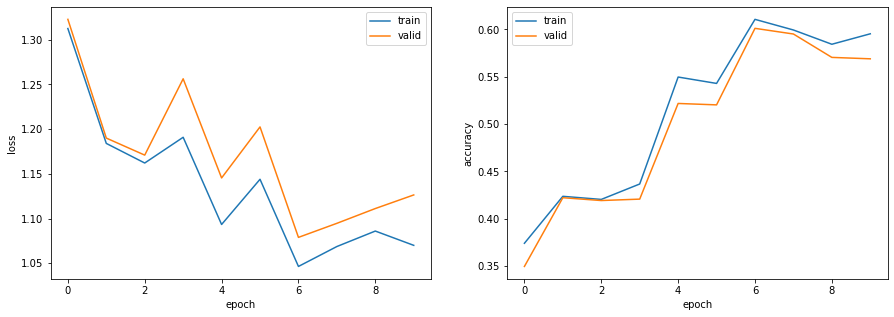

正解率（学習データ）：0.595
正解率（評価データ）：0.564


In [56]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

### #87の方

In [121]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)
    
  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb)).squeeze(3) for i, conv in enumerate(self.convs)]
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [83]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(dataset), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break
      
    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [59]:
import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))


  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 30

  # モデルの定義
  model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.device('cuda')

  # モデルの学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失の算出
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion) 

  return loss_valid 

In [60]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=10800)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2022-01-31 02:49:35,575] A new study created in memory with name: no-name-2c26db54-a404-40e2-886b-c24805676f81


epoch: 1, loss_train: 1.1556, accuracy_train: 0.5051, loss_valid: 1.1583, accuracy_valid: 0.4820, 11.8015sec
epoch: 2, loss_train: 1.1256, accuracy_train: 0.5225, loss_valid: 1.1321, accuracy_valid: 0.5135, 11.7848sec
epoch: 3, loss_train: 1.1042, accuracy_train: 0.5336, loss_valid: 1.1143, accuracy_valid: 0.5254, 11.9607sec
epoch: 4, loss_train: 1.0873, accuracy_train: 0.5426, loss_valid: 1.1002, accuracy_valid: 0.5374, 11.9352sec
epoch: 5, loss_train: 1.0724, accuracy_train: 0.5548, loss_valid: 1.0887, accuracy_valid: 0.5449, 11.9704sec
epoch: 6, loss_train: 1.0580, accuracy_train: 0.5700, loss_valid: 1.0785, accuracy_valid: 0.5561, 11.9415sec
epoch: 7, loss_train: 1.0438, accuracy_train: 0.5830, loss_valid: 1.0678, accuracy_valid: 0.5629, 11.9655sec
epoch: 8, loss_train: 1.0293, accuracy_train: 0.5964, loss_valid: 1.0554, accuracy_valid: 0.5906, 11.9610sec
epoch: 9, loss_train: 1.0149, accuracy_train: 0.6133, loss_valid: 1.0439, accuracy_valid: 0.6003, 11.9427sec
epoch: 10, loss_tra

[I 2022-01-31 02:55:31,841] Trial 0 finished with value: 0.9404063058018818 and parameters: {'emb_size': 400.0, 'out_channels': 50.0, 'drop_rate': 0.1, 'learning_rate': 0.005000301212924522, 'momentum': 0.5, 'batch_size': 64.0}. Best is trial 0 with value: 0.9404063058018818.


epoch: 1, loss_train: 1.1635, accuracy_train: 0.4973, loss_valid: 1.1646, accuracy_valid: 0.4948, 11.6225sec
epoch: 2, loss_train: 1.1448, accuracy_train: 0.5134, loss_valid: 1.1491, accuracy_valid: 0.4918, 11.5952sec
epoch: 3, loss_train: 1.1310, accuracy_train: 0.5154, loss_valid: 1.1379, accuracy_valid: 0.4948, 11.6311sec
epoch: 4, loss_train: 1.1195, accuracy_train: 0.5245, loss_valid: 1.1276, accuracy_valid: 0.5112, 11.7033sec
epoch: 5, loss_train: 1.1094, accuracy_train: 0.5256, loss_valid: 1.1204, accuracy_valid: 0.5090, 11.6052sec
epoch: 6, loss_train: 1.1007, accuracy_train: 0.5328, loss_valid: 1.1136, accuracy_valid: 0.5105, 11.6040sec
epoch: 7, loss_train: 1.0932, accuracy_train: 0.5415, loss_valid: 1.1072, accuracy_valid: 0.5254, 11.6032sec
epoch: 8, loss_train: 1.0866, accuracy_train: 0.5390, loss_valid: 1.1035, accuracy_valid: 0.5135, 11.6373sec
epoch: 9, loss_train: 1.0805, accuracy_train: 0.5500, loss_valid: 1.0984, accuracy_valid: 0.5284, 11.5739sec
epoch: 10, loss_tra

[I 2022-01-31 03:01:21,836] Trial 1 finished with value: 1.060777710728392 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.0, 'learning_rate': 0.001956512828591972, 'momentum': 0.7, 'batch_size': 96.0}. Best is trial 0 with value: 0.9404063058018818.


epoch: 1, loss_train: 1.0743, accuracy_train: 0.5556, loss_valid: 1.0933, accuracy_valid: 0.5352, 11.5065sec
epoch: 2, loss_train: 0.9989, accuracy_train: 0.6324, loss_valid: 1.0325, accuracy_valid: 0.6048, 11.5284sec
epoch: 3, loss_train: 0.9107, accuracy_train: 0.6823, loss_valid: 0.9700, accuracy_valid: 0.6467, 11.5198sec
epoch: 4, loss_train: 0.8283, accuracy_train: 0.7236, loss_valid: 0.9001, accuracy_valid: 0.6864, 11.5214sec
epoch: 5, loss_train: 0.7599, accuracy_train: 0.7424, loss_valid: 0.8558, accuracy_valid: 0.6946, 11.6012sec
epoch: 6, loss_train: 0.6990, accuracy_train: 0.7611, loss_valid: 0.8236, accuracy_valid: 0.7073, 11.5427sec
epoch: 7, loss_train: 0.6473, accuracy_train: 0.7761, loss_valid: 0.7906, accuracy_valid: 0.7148, 11.5482sec
epoch: 8, loss_train: 0.6011, accuracy_train: 0.7888, loss_valid: 0.7602, accuracy_valid: 0.7320, 11.7526sec
epoch: 9, loss_train: 0.5556, accuracy_train: 0.8130, loss_valid: 0.7404, accuracy_valid: 0.7410, 11.5648sec
epoch: 10, loss_tra

[I 2022-01-31 03:07:09,835] Trial 2 finished with value: 0.5980973149706372 and parameters: {'emb_size': 400.0, 'out_channels': 100.0, 'drop_rate': 0.0, 'learning_rate': 0.041762184776111495, 'momentum': 0.5, 'batch_size': 112.0}. Best is trial 2 with value: 0.5980973149706372.


epoch: 1, loss_train: 1.0139, accuracy_train: 0.6339, loss_valid: 1.0474, accuracy_valid: 0.5973, 11.6037sec
epoch: 2, loss_train: 0.8368, accuracy_train: 0.7185, loss_valid: 0.9100, accuracy_valid: 0.6871, 11.5733sec
epoch: 3, loss_train: 0.6997, accuracy_train: 0.7613, loss_valid: 0.8262, accuracy_valid: 0.7088, 11.6103sec
epoch: 4, loss_train: 0.5893, accuracy_train: 0.7900, loss_valid: 0.7510, accuracy_valid: 0.7253, 11.6276sec
epoch: 5, loss_train: 0.4845, accuracy_train: 0.8413, loss_valid: 0.7075, accuracy_valid: 0.7567, 11.6237sec
epoch: 6, loss_train: 0.4021, accuracy_train: 0.8851, loss_valid: 0.6650, accuracy_valid: 0.7717, 11.7010sec
epoch: 7, loss_train: 0.3305, accuracy_train: 0.9077, loss_valid: 0.6237, accuracy_valid: 0.7814, 11.6537sec
epoch: 8, loss_train: 0.2751, accuracy_train: 0.9310, loss_valid: 0.5978, accuracy_valid: 0.7957, 11.6009sec
epoch: 9, loss_train: 0.2288, accuracy_train: 0.9489, loss_valid: 0.5776, accuracy_valid: 0.7949, 11.6004sec
epoch: 10, loss_tra

[I 2022-01-31 03:12:59,269] Trial 3 finished with value: 0.5220585539479822 and parameters: {'emb_size': 200.0, 'out_channels': 200.0, 'drop_rate': 0.0, 'learning_rate': 0.012230412525875069, 'momentum': 0.9, 'batch_size': 80.0}. Best is trial 3 with value: 0.5220585539479822.


epoch: 1, loss_train: 1.1789, accuracy_train: 0.4954, loss_valid: 1.1775, accuracy_valid: 0.4596, 11.8997sec
epoch: 2, loss_train: 1.1602, accuracy_train: 0.5043, loss_valid: 1.1631, accuracy_valid: 0.4753, 11.9327sec
epoch: 3, loss_train: 1.1500, accuracy_train: 0.5077, loss_valid: 1.1547, accuracy_valid: 0.4798, 11.9255sec
epoch: 4, loss_train: 1.1419, accuracy_train: 0.5121, loss_valid: 1.1476, accuracy_valid: 0.4843, 11.8669sec
epoch: 5, loss_train: 1.1349, accuracy_train: 0.5119, loss_valid: 1.1423, accuracy_valid: 0.4828, 11.9300sec
epoch: 6, loss_train: 1.1287, accuracy_train: 0.5167, loss_valid: 1.1366, accuracy_valid: 0.4918, 11.9025sec
epoch: 7, loss_train: 1.1232, accuracy_train: 0.5181, loss_valid: 1.1326, accuracy_valid: 0.4955, 12.0036sec
epoch: 8, loss_train: 1.1180, accuracy_train: 0.5212, loss_valid: 1.1284, accuracy_valid: 0.4955, 11.9126sec
epoch: 9, loss_train: 1.1135, accuracy_train: 0.5272, loss_valid: 1.1241, accuracy_valid: 0.5007, 11.9234sec
epoch: 10, loss_tra

[I 2022-01-31 03:18:58,308] Trial 4 finished with value: 1.1004451489310243 and parameters: {'emb_size': 400.0, 'out_channels': 150.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.00053352206861938, 'momentum': 0.7, 'batch_size': 48.0}. Best is trial 3 with value: 0.5220585539479822.


epoch: 1, loss_train: 0.9119, accuracy_train: 0.6502, loss_valid: 0.9619, accuracy_valid: 0.6190, 11.4686sec
epoch: 2, loss_train: 0.6703, accuracy_train: 0.7638, loss_valid: 0.8052, accuracy_valid: 0.7036, 11.4672sec
epoch: 3, loss_train: 0.5034, accuracy_train: 0.8181, loss_valid: 0.7021, accuracy_valid: 0.7365, 11.4829sec
epoch: 4, loss_train: 0.3674, accuracy_train: 0.8881, loss_valid: 0.6251, accuracy_valid: 0.7874, 11.4547sec
epoch: 5, loss_train: 0.2848, accuracy_train: 0.9271, loss_valid: 0.6181, accuracy_valid: 0.7769, 11.4828sec
epoch: 6, loss_train: 0.2018, accuracy_train: 0.9503, loss_valid: 0.5411, accuracy_valid: 0.8106, 11.4840sec
epoch: 7, loss_train: 0.1424, accuracy_train: 0.9791, loss_valid: 0.5121, accuracy_valid: 0.8226, 11.5595sec
epoch: 8, loss_train: 0.1068, accuracy_train: 0.9895, loss_valid: 0.5081, accuracy_valid: 0.8271, 11.4924sec
epoch: 9, loss_train: 0.0829, accuracy_train: 0.9950, loss_valid: 0.5006, accuracy_valid: 0.8263, 11.4470sec
epoch: 10, loss_tra

[I 2022-01-31 03:24:09,963] Trial 5 finished with value: 0.4833209670493967 and parameters: {'emb_size': 300.0, 'out_channels': 200.0, 'drop_rate': 0.4, 'learning_rate': 0.03317433225774624, 'momentum': 0.9, 'batch_size': 112.0}. Best is trial 5 with value: 0.4833209670493967.


epoch: 1, loss_train: 1.0978, accuracy_train: 0.5293, loss_valid: 1.1102, accuracy_valid: 0.5127, 11.6352sec
epoch: 2, loss_train: 1.0540, accuracy_train: 0.5681, loss_valid: 1.0774, accuracy_valid: 0.5659, 11.5983sec
epoch: 3, loss_train: 1.0086, accuracy_train: 0.6320, loss_valid: 1.0419, accuracy_valid: 0.5936, 11.5698sec
epoch: 4, loss_train: 0.9591, accuracy_train: 0.6637, loss_valid: 0.9981, accuracy_valid: 0.6385, 11.5398sec
epoch: 5, loss_train: 0.9077, accuracy_train: 0.6864, loss_valid: 0.9633, accuracy_valid: 0.6527, 11.5491sec
epoch: 6, loss_train: 0.8587, accuracy_train: 0.7145, loss_valid: 0.9254, accuracy_valid: 0.6766, 11.5548sec
epoch: 7, loss_train: 0.8156, accuracy_train: 0.7276, loss_valid: 0.8990, accuracy_valid: 0.6879, 11.5701sec
epoch: 8, loss_train: 0.7789, accuracy_train: 0.7361, loss_valid: 0.8710, accuracy_valid: 0.6864, 11.5607sec
epoch: 9, loss_train: 0.7435, accuracy_train: 0.7501, loss_valid: 0.8539, accuracy_valid: 0.7006, 11.5457sec
epoch: 10, loss_tra

[I 2022-01-31 03:29:58,462] Trial 6 finished with value: 0.7141811829303429 and parameters: {'emb_size': 200.0, 'out_channels': 200.0, 'drop_rate': 0.0, 'learning_rate': 0.012287269450530902, 'momentum': 0.7, 'batch_size': 96.0}. Best is trial 5 with value: 0.4833209670493967.


epoch: 1, loss_train: 1.0923, accuracy_train: 0.5469, loss_valid: 1.1040, accuracy_valid: 0.5382, 11.6560sec
epoch: 2, loss_train: 1.0455, accuracy_train: 0.5699, loss_valid: 1.0671, accuracy_valid: 0.5584, 11.7641sec
epoch: 3, loss_train: 0.9936, accuracy_train: 0.6357, loss_valid: 1.0316, accuracy_valid: 0.6123, 11.6610sec
epoch: 4, loss_train: 0.9372, accuracy_train: 0.6809, loss_valid: 0.9850, accuracy_valid: 0.6475, 11.6794sec
epoch: 5, loss_train: 0.8823, accuracy_train: 0.7105, loss_valid: 0.9433, accuracy_valid: 0.6692, 11.6676sec
epoch: 6, loss_train: 0.8317, accuracy_train: 0.7185, loss_valid: 0.9066, accuracy_valid: 0.6811, 11.6757sec
epoch: 7, loss_train: 0.7871, accuracy_train: 0.7372, loss_valid: 0.8757, accuracy_valid: 0.6939, 11.6598sec
epoch: 8, loss_train: 0.7477, accuracy_train: 0.7476, loss_valid: 0.8531, accuracy_valid: 0.7036, 11.6629sec
epoch: 9, loss_train: 0.7134, accuracy_train: 0.7602, loss_valid: 0.8332, accuracy_valid: 0.7013, 11.6652sec
epoch: 10, loss_tra

[I 2022-01-31 03:35:49,817] Trial 7 finished with value: 0.6928138312680471 and parameters: {'emb_size': 300.0, 'out_channels': 150.0, 'drop_rate': 0.0, 'learning_rate': 0.009060039130283925, 'momentum': 0.8, 'batch_size': 96.0}. Best is trial 5 with value: 0.4833209670493967.


epoch: 1, loss_train: 1.2361, accuracy_train: 0.4312, loss_valid: 1.2314, accuracy_valid: 0.4356, 11.4859sec
epoch: 2, loss_train: 1.1921, accuracy_train: 0.4731, loss_valid: 1.1893, accuracy_valid: 0.4633, 11.4932sec
epoch: 3, loss_train: 1.1754, accuracy_train: 0.4915, loss_valid: 1.1751, accuracy_valid: 0.4708, 11.5758sec
epoch: 4, loss_train: 1.1665, accuracy_train: 0.4961, loss_valid: 1.1681, accuracy_valid: 0.4716, 11.5156sec
epoch: 5, loss_train: 1.1603, accuracy_train: 0.4973, loss_valid: 1.1632, accuracy_valid: 0.4746, 11.5323sec
epoch: 6, loss_train: 1.1555, accuracy_train: 0.4994, loss_valid: 1.1592, accuracy_valid: 0.4738, 11.4934sec
epoch: 7, loss_train: 1.1513, accuracy_train: 0.5019, loss_valid: 1.1556, accuracy_valid: 0.4790, 11.4876sec
epoch: 8, loss_train: 1.1476, accuracy_train: 0.5043, loss_valid: 1.1525, accuracy_valid: 0.4783, 11.6129sec
epoch: 9, loss_train: 1.1442, accuracy_train: 0.5058, loss_valid: 1.1497, accuracy_valid: 0.4813, 11.5050sec
epoch: 10, loss_tra

[I 2022-01-31 03:41:36,810] Trial 8 finished with value: 1.1296518356678729 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.4, 'learning_rate': 0.0006638858933895832, 'momentum': 0.7, 'batch_size': 112.0}. Best is trial 5 with value: 0.4833209670493967.


epoch: 1, loss_train: 1.1568, accuracy_train: 0.4973, loss_valid: 1.1594, accuracy_valid: 0.4716, 11.5316sec
epoch: 2, loss_train: 1.1275, accuracy_train: 0.5090, loss_valid: 1.1357, accuracy_valid: 0.4813, 11.4963sec
epoch: 3, loss_train: 1.1064, accuracy_train: 0.5320, loss_valid: 1.1172, accuracy_valid: 0.5157, 11.4918sec
epoch: 4, loss_train: 1.0900, accuracy_train: 0.5415, loss_valid: 1.1034, accuracy_valid: 0.5374, 11.5792sec
epoch: 5, loss_train: 1.0756, accuracy_train: 0.5527, loss_valid: 1.0930, accuracy_valid: 0.5314, 11.5152sec
epoch: 6, loss_train: 1.0625, accuracy_train: 0.5659, loss_valid: 1.0829, accuracy_valid: 0.5457, 11.5372sec
epoch: 7, loss_train: 1.0499, accuracy_train: 0.5758, loss_valid: 1.0741, accuracy_valid: 0.5561, 11.5263sec
epoch: 8, loss_train: 1.0373, accuracy_train: 0.5890, loss_valid: 1.0627, accuracy_valid: 0.5853, 11.4925sec
epoch: 9, loss_train: 1.0247, accuracy_train: 0.6100, loss_valid: 1.0539, accuracy_valid: 0.5891, 11.4680sec
epoch: 10, loss_tra

[I 2022-01-31 03:47:23,179] Trial 9 finished with value: 0.9583464366478656 and parameters: {'emb_size': 400.0, 'out_channels': 50.0, 'drop_rate': 0.4, 'learning_rate': 0.0017746425144218704, 'momentum': 0.9, 'batch_size': 112.0}. Best is trial 5 with value: 0.4833209670493967.


epoch: 1, loss_train: 0.5581, accuracy_train: 0.7950, loss_valid: 0.7181, accuracy_valid: 0.7268, 13.0617sec
epoch: 2, loss_train: 0.3676, accuracy_train: 0.8898, loss_valid: 0.6275, accuracy_valid: 0.7844, 13.1143sec
epoch: 3, loss_train: 0.2731, accuracy_train: 0.8987, loss_valid: 0.6344, accuracy_valid: 0.7807, 13.0870sec
epoch: 4, loss_train: 0.1262, accuracy_train: 0.9686, loss_valid: 0.5394, accuracy_valid: 0.8159, 13.0848sec
epoch: 5, loss_train: 0.0904, accuracy_train: 0.9799, loss_valid: 0.5538, accuracy_valid: 0.8226, 13.2256sec
epoch: 6, loss_train: 0.0770, accuracy_train: 0.9744, loss_valid: 0.6016, accuracy_valid: 0.8114, 13.0782sec
epoch: 7, loss_train: 0.0429, accuracy_train: 0.9896, loss_valid: 0.5400, accuracy_valid: 0.8376, 13.0965sec
epoch: 8, loss_train: 0.0307, accuracy_train: 0.9951, loss_valid: 0.5341, accuracy_valid: 0.8353, 13.0729sec
epoch: 9, loss_train: 0.0239, accuracy_train: 0.9958, loss_valid: 0.5570, accuracy_valid: 0.8451, 13.0814sec
epoch: 10, loss_tra

[I 2022-01-31 03:50:27,795] Trial 10 finished with value: 0.5868381204788587 and parameters: {'emb_size': 300.0, 'out_channels': 200.0, 'drop_rate': 0.5, 'learning_rate': 0.04789072048962093, 'momentum': 0.8, 'batch_size': 16.0}. Best is trial 5 with value: 0.4833209670493967.


epoch: 1, loss_train: 1.0278, accuracy_train: 0.5689, loss_valid: 1.0658, accuracy_valid: 0.5576, 11.4243sec
epoch: 2, loss_train: 0.8661, accuracy_train: 0.7083, loss_valid: 0.9365, accuracy_valid: 0.6729, 11.4765sec
epoch: 3, loss_train: 0.7354, accuracy_train: 0.7422, loss_valid: 0.8386, accuracy_valid: 0.6931, 11.4740sec
epoch: 4, loss_train: 0.6281, accuracy_train: 0.7886, loss_valid: 0.7906, accuracy_valid: 0.7275, 11.4777sec
epoch: 5, loss_train: 0.5332, accuracy_train: 0.8066, loss_valid: 0.7179, accuracy_valid: 0.7343, 11.4656sec
epoch: 6, loss_train: 0.4612, accuracy_train: 0.8578, loss_valid: 0.7091, accuracy_valid: 0.7328, 11.4570sec
epoch: 7, loss_train: 0.3898, accuracy_train: 0.8857, loss_valid: 0.6661, accuracy_valid: 0.7635, 11.4283sec
epoch: 8, loss_train: 0.3242, accuracy_train: 0.9092, loss_valid: 0.6161, accuracy_valid: 0.7777, 11.4500sec
epoch: 9, loss_train: 0.2827, accuracy_train: 0.9455, loss_valid: 0.6218, accuracy_valid: 0.7919, 11.4761sec
epoch: 10, loss_tra

[I 2022-01-31 03:56:13,505] Trial 11 finished with value: 0.5123524862135586 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.2, 'learning_rate': 0.018671821485595153, 'momentum': 0.9, 'batch_size': 128.0}. Best is trial 5 with value: 0.4833209670493967.


epoch: 1, loss_train: 0.9833, accuracy_train: 0.6439, loss_valid: 1.0194, accuracy_valid: 0.6243, 11.5278sec
epoch: 2, loss_train: 0.7854, accuracy_train: 0.7358, loss_valid: 0.8687, accuracy_valid: 0.6991, 11.5090sec
epoch: 3, loss_train: 0.6416, accuracy_train: 0.7808, loss_valid: 0.7879, accuracy_valid: 0.7313, 11.4605sec
epoch: 4, loss_train: 0.5181, accuracy_train: 0.8172, loss_valid: 0.7029, accuracy_valid: 0.7537, 11.4782sec
epoch: 5, loss_train: 0.4214, accuracy_train: 0.8721, loss_valid: 0.6627, accuracy_valid: 0.7725, 11.5561sec
epoch: 6, loss_train: 0.3405, accuracy_train: 0.8943, loss_valid: 0.6093, accuracy_valid: 0.7792, 11.5292sec
epoch: 7, loss_train: 0.2680, accuracy_train: 0.9247, loss_valid: 0.5723, accuracy_valid: 0.7957, 11.4826sec
epoch: 8, loss_train: 0.2116, accuracy_train: 0.9584, loss_valid: 0.5540, accuracy_valid: 0.8129, 11.4853sec
epoch: 9, loss_train: 0.1742, accuracy_train: 0.9718, loss_valid: 0.5389, accuracy_valid: 0.8159, 11.4596sec
epoch: 10, loss_tra

[I 2022-01-31 04:01:59,726] Trial 12 finished with value: 0.48680765497145123 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.2, 'learning_rate': 0.02402449485037946, 'momentum': 0.9, 'batch_size': 128.0}. Best is trial 5 with value: 0.4833209670493967.


epoch: 1, loss_train: 1.0467, accuracy_train: 0.5615, loss_valid: 1.0738, accuracy_valid: 0.5412, 11.4557sec
epoch: 2, loss_train: 0.9356, accuracy_train: 0.6722, loss_valid: 0.9815, accuracy_valid: 0.6452, 11.4822sec
epoch: 3, loss_train: 0.8265, accuracy_train: 0.7148, loss_valid: 0.9053, accuracy_valid: 0.6669, 11.5036sec
epoch: 4, loss_train: 0.7357, accuracy_train: 0.7515, loss_valid: 0.8409, accuracy_valid: 0.7043, 11.4529sec
epoch: 5, loss_train: 0.6555, accuracy_train: 0.7716, loss_valid: 0.7999, accuracy_valid: 0.7096, 11.4594sec
epoch: 6, loss_train: 0.5763, accuracy_train: 0.8022, loss_valid: 0.7493, accuracy_valid: 0.7380, 11.4741sec
epoch: 7, loss_train: 0.5162, accuracy_train: 0.8367, loss_valid: 0.7239, accuracy_valid: 0.7485, 11.4726sec
epoch: 8, loss_train: 0.4598, accuracy_train: 0.8528, loss_valid: 0.6854, accuracy_valid: 0.7605, 11.4892sec
epoch: 9, loss_train: 0.4089, accuracy_train: 0.8668, loss_valid: 0.6517, accuracy_valid: 0.7627, 11.4434sec
epoch: 10, loss_tra

[I 2022-01-31 04:07:45,711] Trial 13 finished with value: 0.529236849600456 and parameters: {'emb_size': 300.0, 'out_channels': 200.0, 'drop_rate': 0.2, 'learning_rate': 0.026429528126102365, 'momentum': 0.8, 'batch_size': 128.0}. Best is trial 5 with value: 0.4833209670493967.


epoch: 1, loss_train: 0.9528, accuracy_train: 0.6655, loss_valid: 1.0050, accuracy_valid: 0.6355, 11.4995sec
epoch: 2, loss_train: 0.7380, accuracy_train: 0.7449, loss_valid: 0.8449, accuracy_valid: 0.6976, 11.4848sec
epoch: 3, loss_train: 0.5907, accuracy_train: 0.7805, loss_valid: 0.7521, accuracy_valid: 0.7148, 11.4933sec
epoch: 4, loss_train: 0.4552, accuracy_train: 0.8472, loss_valid: 0.6744, accuracy_valid: 0.7590, 11.7047sec
epoch: 5, loss_train: 0.3476, accuracy_train: 0.8943, loss_valid: 0.6182, accuracy_valid: 0.7867, 11.4708sec
epoch: 6, loss_train: 0.2709, accuracy_train: 0.9185, loss_valid: 0.5682, accuracy_valid: 0.8016, 11.4990sec
epoch: 7, loss_train: 0.2079, accuracy_train: 0.9506, loss_valid: 0.5428, accuracy_valid: 0.8099, 11.4999sec
epoch: 8, loss_train: 0.1639, accuracy_train: 0.9664, loss_valid: 0.5275, accuracy_valid: 0.8181, 11.4467sec
epoch: 9, loss_train: 0.1246, accuracy_train: 0.9864, loss_valid: 0.5056, accuracy_valid: 0.8301, 11.4558sec
epoch: 10, loss_tra

[I 2022-01-31 04:13:32,262] Trial 14 finished with value: 0.4805841083354471 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.031120205184316862, 'momentum': 0.9, 'batch_size': 128.0}. Best is trial 14 with value: 0.4805841083354471.


epoch: 1, loss_train: 1.1100, accuracy_train: 0.5195, loss_valid: 1.1209, accuracy_valid: 0.4933, 11.7174sec
epoch: 2, loss_train: 1.0724, accuracy_train: 0.5507, loss_valid: 1.0944, accuracy_valid: 0.5240, 11.7167sec
epoch: 3, loss_train: 1.0386, accuracy_train: 0.5860, loss_valid: 1.0634, accuracy_valid: 0.5853, 11.7148sec
epoch: 4, loss_train: 1.0013, accuracy_train: 0.6324, loss_valid: 1.0380, accuracy_valid: 0.6153, 11.7302sec
epoch: 5, loss_train: 0.9602, accuracy_train: 0.6605, loss_valid: 1.0035, accuracy_valid: 0.6415, 11.7685sec
epoch: 6, loss_train: 0.9195, accuracy_train: 0.6942, loss_valid: 0.9720, accuracy_valid: 0.6572, 11.7202sec
epoch: 7, loss_train: 0.8810, accuracy_train: 0.7029, loss_valid: 0.9437, accuracy_valid: 0.6662, 11.7075sec
epoch: 8, loss_train: 0.8457, accuracy_train: 0.7167, loss_valid: 0.9128, accuracy_valid: 0.6819, 11.7300sec
epoch: 9, loss_train: 0.8136, accuracy_train: 0.7316, loss_valid: 0.8953, accuracy_valid: 0.6909, 11.7660sec
epoch: 10, loss_tra

[I 2022-01-31 04:19:25,236] Trial 15 finished with value: 0.7594928462846026 and parameters: {'emb_size': 200.0, 'out_channels': 150.0, 'drop_rate': 0.4, 'learning_rate': 0.00492470217739694, 'momentum': 0.8, 'batch_size': 64.0}. Best is trial 14 with value: 0.4805841083354471.


epoch: 1, loss_train: 1.0489, accuracy_train: 0.5766, loss_valid: 1.0693, accuracy_valid: 0.5801, 13.0989sec
epoch: 2, loss_train: 0.9431, accuracy_train: 0.6771, loss_valid: 0.9880, accuracy_valid: 0.6504, 13.2380sec
epoch: 3, loss_train: 0.8406, accuracy_train: 0.7233, loss_valid: 0.9078, accuracy_valid: 0.6864, 13.1149sec
epoch: 4, loss_train: 0.7574, accuracy_train: 0.7466, loss_valid: 0.8527, accuracy_valid: 0.7013, 13.1195sec
epoch: 5, loss_train: 0.6857, accuracy_train: 0.7668, loss_valid: 0.8067, accuracy_valid: 0.7111, 13.1565sec
epoch: 6, loss_train: 0.6257, accuracy_train: 0.7858, loss_valid: 0.7749, accuracy_valid: 0.7246, 13.2244sec
epoch: 7, loss_train: 0.5697, accuracy_train: 0.7940, loss_valid: 0.7340, accuracy_valid: 0.7246, 13.1387sec
epoch: 8, loss_train: 0.5230, accuracy_train: 0.8113, loss_valid: 0.7112, accuracy_valid: 0.7328, 13.1537sec
epoch: 9, loss_train: 0.4720, accuracy_train: 0.8459, loss_valid: 0.6897, accuracy_valid: 0.7522, 13.1710sec
epoch: 10, loss_tra

[I 2022-01-31 04:26:02,375] Trial 16 finished with value: 0.5455203516543771 and parameters: {'emb_size': 300.0, 'out_channels': 100.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.006326837383545188, 'momentum': 0.6, 'batch_size': 16.0}. Best is trial 14 with value: 0.4805841083354471.


epoch: 1, loss_train: 0.8508, accuracy_train: 0.7053, loss_valid: 0.9163, accuracy_valid: 0.6707, 11.6694sec
epoch: 2, loss_train: 0.6302, accuracy_train: 0.7724, loss_valid: 0.7711, accuracy_valid: 0.7231, 11.6664sec
epoch: 3, loss_train: 0.4612, accuracy_train: 0.8406, loss_valid: 0.6638, accuracy_valid: 0.7522, 11.8098sec
epoch: 4, loss_train: 0.3523, accuracy_train: 0.8958, loss_valid: 0.6295, accuracy_valid: 0.7852, 11.6691sec
epoch: 5, loss_train: 0.2389, accuracy_train: 0.9434, loss_valid: 0.5467, accuracy_valid: 0.8084, 11.6791sec
epoch: 6, loss_train: 0.1771, accuracy_train: 0.9556, loss_valid: 0.5186, accuracy_valid: 0.8129, 11.6520sec
epoch: 7, loss_train: 0.1297, accuracy_train: 0.9803, loss_valid: 0.5070, accuracy_valid: 0.8256, 11.6681sec
epoch: 8, loss_train: 0.0967, accuracy_train: 0.9902, loss_valid: 0.4953, accuracy_valid: 0.8241, 11.6789sec
epoch: 9, loss_train: 0.0765, accuracy_train: 0.9934, loss_valid: 0.4900, accuracy_valid: 0.8353, 11.6677sec
epoch: 10, loss_tra

[I 2022-01-31 04:29:22,320] Trial 17 finished with value: 0.46931558681526003 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.029511879912192323, 'momentum': 0.9, 'batch_size': 80.0}. Best is trial 17 with value: 0.46931558681526003.


epoch: 1, loss_train: 1.0710, accuracy_train: 0.5519, loss_valid: 1.1007, accuracy_valid: 0.5187, 11.8944sec
epoch: 2, loss_train: 0.9945, accuracy_train: 0.6375, loss_valid: 1.0368, accuracy_valid: 0.6123, 11.9068sec
epoch: 3, loss_train: 0.9106, accuracy_train: 0.7023, loss_valid: 0.9682, accuracy_valid: 0.6669, 11.9060sec
epoch: 4, loss_train: 0.8344, accuracy_train: 0.7175, loss_valid: 0.9116, accuracy_valid: 0.6707, 11.8911sec
epoch: 5, loss_train: 0.7716, accuracy_train: 0.7416, loss_valid: 0.8662, accuracy_valid: 0.6999, 11.8918sec
epoch: 6, loss_train: 0.7091, accuracy_train: 0.7582, loss_valid: 0.8336, accuracy_valid: 0.7118, 12.0296sec
epoch: 7, loss_train: 0.6571, accuracy_train: 0.7785, loss_valid: 0.7973, accuracy_valid: 0.7171, 12.0999sec
epoch: 8, loss_train: 0.6126, accuracy_train: 0.7872, loss_valid: 0.7667, accuracy_valid: 0.7246, 11.9892sec
epoch: 9, loss_train: 0.5698, accuracy_train: 0.8053, loss_valid: 0.7454, accuracy_valid: 0.7365, 11.9444sec
epoch: 10, loss_tra

[I 2022-01-31 04:35:22,289] Trial 18 finished with value: 0.5925322602097967 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.015149825641773196, 'momentum': 0.6, 'batch_size': 48.0}. Best is trial 17 with value: 0.46931558681526003.


epoch: 1, loss_train: 1.1410, accuracy_train: 0.5205, loss_valid: 1.1456, accuracy_valid: 0.4948, 11.6052sec
epoch: 2, loss_train: 1.1122, accuracy_train: 0.5334, loss_valid: 1.1202, accuracy_valid: 0.5225, 11.6718sec
epoch: 3, loss_train: 1.0911, accuracy_train: 0.5456, loss_valid: 1.1044, accuracy_valid: 0.5292, 11.6292sec
epoch: 4, loss_train: 1.0741, accuracy_train: 0.5574, loss_valid: 1.0893, accuracy_valid: 0.5546, 11.6272sec
epoch: 5, loss_train: 1.0582, accuracy_train: 0.5726, loss_valid: 1.0786, accuracy_valid: 0.5591, 11.6257sec
epoch: 6, loss_train: 1.0433, accuracy_train: 0.5860, loss_valid: 1.0682, accuracy_valid: 0.5741, 11.6209sec
epoch: 7, loss_train: 1.0277, accuracy_train: 0.6030, loss_valid: 1.0557, accuracy_valid: 0.5921, 11.8315sec
epoch: 8, loss_train: 1.0125, accuracy_train: 0.6263, loss_valid: 1.0435, accuracy_valid: 0.6025, 11.7308sec
epoch: 9, loss_train: 0.9966, accuracy_train: 0.6444, loss_valid: 1.0310, accuracy_valid: 0.6138, 11.7042sec
epoch: 10, loss_tra

[I 2022-01-31 04:41:13,976] Trial 19 finished with value: 0.9233203586386126 and parameters: {'emb_size': 100.0, 'out_channels': 100.0, 'drop_rate': 0.5, 'learning_rate': 0.002878064804832101, 'momentum': 0.8, 'batch_size': 80.0}. Best is trial 17 with value: 0.46931558681526003.


epoch: 1, loss_train: 0.6384, accuracy_train: 0.7691, loss_valid: 0.7804, accuracy_valid: 0.7111, 12.1962sec
epoch: 2, loss_train: 0.3820, accuracy_train: 0.8802, loss_valid: 0.6490, accuracy_valid: 0.7672, 12.2030sec
epoch: 3, loss_train: 0.2090, accuracy_train: 0.9477, loss_valid: 0.5494, accuracy_valid: 0.8106, 12.2189sec
epoch: 4, loss_train: 0.1123, accuracy_train: 0.9806, loss_valid: 0.5197, accuracy_valid: 0.8211, 12.3385sec
epoch: 5, loss_train: 0.0683, accuracy_train: 0.9920, loss_valid: 0.5094, accuracy_valid: 0.8249, 12.2557sec
epoch: 6, loss_train: 0.0423, accuracy_train: 0.9954, loss_valid: 0.5207, accuracy_valid: 0.8204, 12.2163sec
epoch: 7, loss_train: 0.0303, accuracy_train: 0.9974, loss_valid: 0.5309, accuracy_valid: 0.8293, 12.4053sec
epoch: 8, loss_train: 0.0222, accuracy_train: 0.9977, loss_valid: 0.5300, accuracy_valid: 0.8249, 12.2156sec
epoch: 9, loss_train: 0.0171, accuracy_train: 0.9987, loss_valid: 0.5238, accuracy_valid: 0.8361, 12.2282sec
epoch: 10, loss_tra

[I 2022-01-31 04:45:57,511] Trial 20 finished with value: 0.5290512206013483 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.024723468614167896, 'momentum': 0.9, 'batch_size': 32.0}. Best is trial 17 with value: 0.46931558681526003.


epoch: 1, loss_train: 0.8930, accuracy_train: 0.6970, loss_valid: 0.9531, accuracy_valid: 0.6669, 11.5894sec
epoch: 2, loss_train: 0.6601, accuracy_train: 0.7676, loss_valid: 0.7913, accuracy_valid: 0.7103, 11.5837sec
epoch: 3, loss_train: 0.5008, accuracy_train: 0.8156, loss_valid: 0.6934, accuracy_valid: 0.7388, 11.5870sec
epoch: 4, loss_train: 0.3646, accuracy_train: 0.8917, loss_valid: 0.6213, accuracy_valid: 0.7844, 11.6753sec
epoch: 5, loss_train: 0.2719, accuracy_train: 0.9335, loss_valid: 0.5941, accuracy_valid: 0.7994, 11.5632sec
epoch: 6, loss_train: 0.1954, accuracy_train: 0.9535, loss_valid: 0.5477, accuracy_valid: 0.8106, 11.4965sec
epoch: 7, loss_train: 0.1429, accuracy_train: 0.9824, loss_valid: 0.5211, accuracy_valid: 0.8174, 11.5454sec
epoch: 8, loss_train: 0.1097, accuracy_train: 0.9862, loss_valid: 0.5111, accuracy_valid: 0.8241, 11.5209sec
epoch: 9, loss_train: 0.0870, accuracy_train: 0.9942, loss_valid: 0.5147, accuracy_valid: 0.8323, 11.5039sec
epoch: 10, loss_tra

[I 2022-01-31 04:51:44,946] Trial 21 finished with value: 0.4817325620896798 and parameters: {'emb_size': 200.0, 'out_channels': 150.0, 'drop_rate': 0.4, 'learning_rate': 0.03572896674556991, 'momentum': 0.9, 'batch_size': 112.0}. Best is trial 17 with value: 0.46931558681526003.


epoch: 1, loss_train: 0.9338, accuracy_train: 0.6663, loss_valid: 0.9823, accuracy_valid: 0.6362, 11.4611sec
epoch: 2, loss_train: 0.7238, accuracy_train: 0.7493, loss_valid: 0.8311, accuracy_valid: 0.7073, 11.4741sec
epoch: 3, loss_train: 0.5692, accuracy_train: 0.7949, loss_valid: 0.7369, accuracy_valid: 0.7335, 11.4604sec
epoch: 4, loss_train: 0.4382, accuracy_train: 0.8497, loss_valid: 0.6581, accuracy_valid: 0.7650, 11.4401sec
epoch: 5, loss_train: 0.3393, accuracy_train: 0.9131, loss_valid: 0.6146, accuracy_valid: 0.7852, 11.5785sec
epoch: 6, loss_train: 0.2707, accuracy_train: 0.9147, loss_valid: 0.5744, accuracy_valid: 0.8039, 11.5238sec
epoch: 7, loss_train: 0.2071, accuracy_train: 0.9592, loss_valid: 0.5552, accuracy_valid: 0.8196, 11.4958sec
epoch: 8, loss_train: 0.1623, accuracy_train: 0.9616, loss_valid: 0.5176, accuracy_valid: 0.8174, 11.5297sec
epoch: 9, loss_train: 0.1265, accuracy_train: 0.9809, loss_valid: 0.5090, accuracy_valid: 0.8263, 11.5130sec
epoch: 10, loss_tra

[I 2022-01-31 04:55:59,294] Trial 22 finished with value: 0.4708041436061699 and parameters: {'emb_size': 200.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.03615834500817805, 'momentum': 0.9, 'batch_size': 128.0}. Best is trial 17 with value: 0.46931558681526003.


epoch: 1, loss_train: 0.9857, accuracy_train: 0.6207, loss_valid: 1.0313, accuracy_valid: 0.5981, 11.4978sec
epoch: 2, loss_train: 0.8080, accuracy_train: 0.7204, loss_valid: 0.8834, accuracy_valid: 0.6722, 11.5157sec
epoch: 3, loss_train: 0.6726, accuracy_train: 0.7687, loss_valid: 0.8051, accuracy_valid: 0.7141, 11.5109sec
epoch: 4, loss_train: 0.5609, accuracy_train: 0.8016, loss_valid: 0.7327, accuracy_valid: 0.7350, 11.5960sec
epoch: 5, loss_train: 0.4702, accuracy_train: 0.8459, loss_valid: 0.6870, accuracy_valid: 0.7493, 11.4998sec
epoch: 6, loss_train: 0.3988, accuracy_train: 0.8594, loss_valid: 0.6397, accuracy_valid: 0.7575, 11.4544sec
epoch: 7, loss_train: 0.3255, accuracy_train: 0.9163, loss_valid: 0.6113, accuracy_valid: 0.7934, 11.4482sec
epoch: 8, loss_train: 0.2737, accuracy_train: 0.9327, loss_valid: 0.5743, accuracy_valid: 0.8031, 11.4824sec
epoch: 9, loss_train: 0.2404, accuracy_train: 0.9274, loss_valid: 0.5625, accuracy_valid: 0.7912, 11.4672sec
epoch: 10, loss_tra

[I 2022-01-31 05:01:45,291] Trial 23 finished with value: 0.4732431232797481 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.049686129348692494, 'momentum': 0.8, 'batch_size': 128.0}. Best is trial 17 with value: 0.46931558681526003.


epoch: 1, loss_train: 0.9396, accuracy_train: 0.6467, loss_valid: 0.9887, accuracy_valid: 0.6220, 11.5624sec
epoch: 2, loss_train: 0.7488, accuracy_train: 0.7363, loss_valid: 0.8430, accuracy_valid: 0.6826, 11.5635sec
epoch: 3, loss_train: 0.6085, accuracy_train: 0.7762, loss_valid: 0.7612, accuracy_valid: 0.7193, 11.5707sec
epoch: 4, loss_train: 0.4872, accuracy_train: 0.8425, loss_valid: 0.6855, accuracy_valid: 0.7597, 11.5588sec
epoch: 5, loss_train: 0.3857, accuracy_train: 0.8795, loss_valid: 0.6234, accuracy_valid: 0.7859, 11.6761sec
epoch: 6, loss_train: 0.3149, accuracy_train: 0.9068, loss_valid: 0.5849, accuracy_valid: 0.8009, 11.7660sec
epoch: 7, loss_train: 0.2552, accuracy_train: 0.9189, loss_valid: 0.5392, accuracy_valid: 0.8016, 11.7198sec
epoch: 8, loss_train: 0.2022, accuracy_train: 0.9619, loss_valid: 0.5269, accuracy_valid: 0.8174, 11.5990sec
epoch: 9, loss_train: 0.1662, accuracy_train: 0.9703, loss_valid: 0.5154, accuracy_valid: 0.8174, 11.5990sec
epoch: 10, loss_tra

[I 2022-01-31 05:07:34,963] Trial 24 finished with value: 0.45671447990712366 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.5, 'learning_rate': 0.04918225279208399, 'momentum': 0.8, 'batch_size': 96.0}. Best is trial 24 with value: 0.45671447990712366.


epoch: 1, loss_train: 1.0476, accuracy_train: 0.5779, loss_valid: 1.0755, accuracy_valid: 0.5734, 11.6034sec
epoch: 2, loss_train: 0.9309, accuracy_train: 0.6902, loss_valid: 0.9782, accuracy_valid: 0.6557, 11.6436sec
epoch: 3, loss_train: 0.8200, accuracy_train: 0.7200, loss_valid: 0.8929, accuracy_valid: 0.6826, 11.6406sec
epoch: 4, loss_train: 0.7326, accuracy_train: 0.7500, loss_valid: 0.8379, accuracy_valid: 0.7073, 11.6574sec
epoch: 5, loss_train: 0.6624, accuracy_train: 0.7695, loss_valid: 0.7882, accuracy_valid: 0.7216, 11.6631sec
epoch: 6, loss_train: 0.5974, accuracy_train: 0.7923, loss_valid: 0.7478, accuracy_valid: 0.7238, 11.7213sec
epoch: 7, loss_train: 0.5379, accuracy_train: 0.8071, loss_valid: 0.7086, accuracy_valid: 0.7358, 11.6601sec
epoch: 8, loss_train: 0.4821, accuracy_train: 0.8424, loss_valid: 0.6775, accuracy_valid: 0.7680, 11.6358sec
epoch: 9, loss_train: 0.4381, accuracy_train: 0.8642, loss_valid: 0.6535, accuracy_valid: 0.7807, 11.6289sec
epoch: 10, loss_tra

[I 2022-01-31 05:13:26,206] Trial 25 finished with value: 0.5053376451216596 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.5, 'learning_rate': 0.0186064505162957, 'momentum': 0.8, 'batch_size': 80.0}. Best is trial 24 with value: 0.45671447990712366.


epoch: 1, loss_train: 1.0632, accuracy_train: 0.5490, loss_valid: 1.0801, accuracy_valid: 0.5516, 11.5285sec
epoch: 2, loss_train: 0.9732, accuracy_train: 0.6628, loss_valid: 1.0142, accuracy_valid: 0.6257, 11.5425sec
epoch: 3, loss_train: 0.8717, accuracy_train: 0.7048, loss_valid: 0.9326, accuracy_valid: 0.6699, 11.5430sec
epoch: 4, loss_train: 0.7950, accuracy_train: 0.7330, loss_valid: 0.8770, accuracy_valid: 0.6841, 11.5873sec
epoch: 5, loss_train: 0.7255, accuracy_train: 0.7534, loss_valid: 0.8290, accuracy_valid: 0.7133, 11.5516sec
epoch: 6, loss_train: 0.6666, accuracy_train: 0.7705, loss_valid: 0.7918, accuracy_valid: 0.7246, 11.5512sec
epoch: 7, loss_train: 0.6183, accuracy_train: 0.7803, loss_valid: 0.7597, accuracy_valid: 0.7320, 11.5813sec
epoch: 8, loss_train: 0.5713, accuracy_train: 0.7976, loss_valid: 0.7361, accuracy_valid: 0.7380, 11.5863sec
epoch: 9, loss_train: 0.5319, accuracy_train: 0.8172, loss_valid: 0.7130, accuracy_valid: 0.7485, 11.5578sec
epoch: 10, loss_tra

[I 2022-01-31 05:19:15,607] Trial 26 finished with value: 0.5664184636875254 and parameters: {'emb_size': 200.0, 'out_channels': 50.0, 'drop_rate': 0.5, 'learning_rate': 0.01925901180852324, 'momentum': 0.8, 'batch_size': 96.0}. Best is trial 24 with value: 0.45671447990712366.


epoch: 1, loss_train: 1.0363, accuracy_train: 0.5630, loss_valid: 1.0592, accuracy_valid: 0.5614, 11.7886sec
epoch: 2, loss_train: 0.9052, accuracy_train: 0.6762, loss_valid: 0.9577, accuracy_valid: 0.6504, 11.8136sec
epoch: 3, loss_train: 0.7879, accuracy_train: 0.7339, loss_valid: 0.8678, accuracy_valid: 0.6999, 11.7676sec
epoch: 4, loss_train: 0.6986, accuracy_train: 0.7566, loss_valid: 0.8200, accuracy_valid: 0.7096, 11.7241sec
epoch: 5, loss_train: 0.6172, accuracy_train: 0.7840, loss_valid: 0.7641, accuracy_valid: 0.7395, 11.7473sec
epoch: 6, loss_train: 0.5471, accuracy_train: 0.8041, loss_valid: 0.7208, accuracy_valid: 0.7463, 11.7480sec
epoch: 7, loss_train: 0.4872, accuracy_train: 0.8475, loss_valid: 0.6971, accuracy_valid: 0.7695, 11.7558sec
epoch: 8, loss_train: 0.4304, accuracy_train: 0.8618, loss_valid: 0.6552, accuracy_valid: 0.7762, 11.8620sec
epoch: 9, loss_train: 0.3844, accuracy_train: 0.8802, loss_valid: 0.6340, accuracy_valid: 0.7784, 11.7510sec
epoch: 10, loss_tra

[I 2022-01-31 05:24:46,278] Trial 27 finished with value: 0.514500136443343 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.4, 'learning_rate': 0.008315135062593676, 'momentum': 0.9, 'batch_size': 64.0}. Best is trial 24 with value: 0.45671447990712366.


epoch: 1, loss_train: 0.9420, accuracy_train: 0.6811, loss_valid: 0.9901, accuracy_valid: 0.6422, 11.6992sec
epoch: 2, loss_train: 0.7445, accuracy_train: 0.7495, loss_valid: 0.8381, accuracy_valid: 0.7163, 11.6787sec
epoch: 3, loss_train: 0.6193, accuracy_train: 0.7829, loss_valid: 0.7667, accuracy_valid: 0.7201, 11.6961sec
epoch: 4, loss_train: 0.5153, accuracy_train: 0.8184, loss_valid: 0.6992, accuracy_valid: 0.7522, 11.6754sec
epoch: 5, loss_train: 0.4151, accuracy_train: 0.8746, loss_valid: 0.6460, accuracy_valid: 0.7747, 11.6877sec
epoch: 6, loss_train: 0.3384, accuracy_train: 0.8874, loss_valid: 0.5983, accuracy_valid: 0.7889, 11.6574sec
epoch: 7, loss_train: 0.2797, accuracy_train: 0.9272, loss_valid: 0.5733, accuracy_valid: 0.8009, 11.6915sec
epoch: 8, loss_train: 0.2245, accuracy_train: 0.9591, loss_valid: 0.5454, accuracy_valid: 0.8091, 11.6573sec
epoch: 9, loss_train: 0.1894, accuracy_train: 0.9539, loss_valid: 0.5206, accuracy_valid: 0.8121, 11.6812sec
epoch: 10, loss_tra

[I 2022-01-31 05:30:38,433] Trial 28 finished with value: 0.4545543969030399 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.5, 'learning_rate': 0.038349148941201186, 'momentum': 0.8, 'batch_size': 80.0}. Best is trial 28 with value: 0.4545543969030399.


epoch: 1, loss_train: 0.9065, accuracy_train: 0.6882, loss_valid: 0.9629, accuracy_valid: 0.6602, 11.9874sec
epoch: 2, loss_train: 0.7204, accuracy_train: 0.7383, loss_valid: 0.8327, accuracy_valid: 0.6789, 12.0577sec
epoch: 3, loss_train: 0.5680, accuracy_train: 0.7998, loss_valid: 0.7433, accuracy_valid: 0.7343, 11.9494sec
epoch: 4, loss_train: 0.4521, accuracy_train: 0.8503, loss_valid: 0.6761, accuracy_valid: 0.7522, 11.8937sec
epoch: 5, loss_train: 0.3407, accuracy_train: 0.9043, loss_valid: 0.6267, accuracy_valid: 0.7859, 11.8855sec
epoch: 6, loss_train: 0.2527, accuracy_train: 0.9331, loss_valid: 0.5650, accuracy_valid: 0.7964, 11.8877sec
epoch: 7, loss_train: 0.1978, accuracy_train: 0.9488, loss_valid: 0.5403, accuracy_valid: 0.8061, 11.8684sec
epoch: 8, loss_train: 0.1497, accuracy_train: 0.9777, loss_valid: 0.5273, accuracy_valid: 0.8241, 11.8491sec
epoch: 9, loss_train: 0.1196, accuracy_train: 0.9854, loss_valid: 0.5256, accuracy_valid: 0.8219, 11.8800sec
epoch: 10, loss_tra

[I 2022-01-31 05:36:01,175] Trial 29 finished with value: 0.49904743500170995 and parameters: {'emb_size': 200.0, 'out_channels': 50.0, 'drop_rate': 0.1, 'learning_rate': 0.04988824628861753, 'momentum': 0.6, 'batch_size': 48.0}. Best is trial 28 with value: 0.4545543969030399.


epoch: 1, loss_train: 1.0151, accuracy_train: 0.6002, loss_valid: 1.0469, accuracy_valid: 0.6003, 11.6169sec
epoch: 2, loss_train: 0.8641, accuracy_train: 0.7111, loss_valid: 0.9281, accuracy_valid: 0.6707, 11.7348sec
epoch: 3, loss_train: 0.7466, accuracy_train: 0.7421, loss_valid: 0.8517, accuracy_valid: 0.6969, 11.6778sec
epoch: 4, loss_train: 0.6490, accuracy_train: 0.7709, loss_valid: 0.7907, accuracy_valid: 0.7103, 11.7387sec
epoch: 5, loss_train: 0.5651, accuracy_train: 0.8074, loss_valid: 0.7431, accuracy_valid: 0.7298, 11.8629sec
epoch: 6, loss_train: 0.4898, accuracy_train: 0.8280, loss_valid: 0.6931, accuracy_valid: 0.7500, 11.6288sec
epoch: 7, loss_train: 0.4245, accuracy_train: 0.8630, loss_valid: 0.6651, accuracy_valid: 0.7612, 11.6168sec
epoch: 8, loss_train: 0.3705, accuracy_train: 0.8889, loss_valid: 0.6383, accuracy_valid: 0.7732, 11.6510sec
epoch: 9, loss_train: 0.3216, accuracy_train: 0.9099, loss_valid: 0.6180, accuracy_valid: 0.7904, 11.6518sec
epoch: 10, loss_tra

[I 2022-01-31 05:41:52,771] Trial 30 finished with value: 0.5034806399902548 and parameters: {'emb_size': 300.0, 'out_channels': 100.0, 'drop_rate': 0.4, 'learning_rate': 0.024255171763687938, 'momentum': 0.8, 'batch_size': 80.0}. Best is trial 28 with value: 0.4545543969030399.


epoch: 1, loss_train: 0.7983, accuracy_train: 0.7261, loss_valid: 0.8895, accuracy_valid: 0.6774, 11.7221sec
epoch: 2, loss_train: 0.5626, accuracy_train: 0.8076, loss_valid: 0.7274, accuracy_valid: 0.7478, 11.7586sec
epoch: 3, loss_train: 0.4063, accuracy_train: 0.8674, loss_valid: 0.6371, accuracy_valid: 0.7769, 11.7434sec
epoch: 4, loss_train: 0.3028, accuracy_train: 0.8908, loss_valid: 0.5714, accuracy_valid: 0.7889, 11.7303sec
epoch: 5, loss_train: 0.2076, accuracy_train: 0.9503, loss_valid: 0.5520, accuracy_valid: 0.8039, 11.8521sec
epoch: 6, loss_train: 0.1475, accuracy_train: 0.9732, loss_valid: 0.5043, accuracy_valid: 0.8263, 11.7453sec
epoch: 7, loss_train: 0.1090, accuracy_train: 0.9838, loss_valid: 0.5084, accuracy_valid: 0.8211, 11.7270sec
epoch: 8, loss_train: 0.0801, accuracy_train: 0.9891, loss_valid: 0.4995, accuracy_valid: 0.8308, 11.7203sec
epoch: 9, loss_train: 0.0627, accuracy_train: 0.9938, loss_valid: 0.4903, accuracy_valid: 0.8353, 11.7287sec
epoch: 10, loss_tra

[I 2022-01-31 05:47:23,070] Trial 31 finished with value: 0.4819942924546351 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.5, 'learning_rate': 0.032307034616129354, 'momentum': 0.9, 'batch_size': 64.0}. Best is trial 28 with value: 0.4545543969030399.


epoch: 1, loss_train: 0.9786, accuracy_train: 0.6514, loss_valid: 1.0113, accuracy_valid: 0.6272, 11.5667sec
epoch: 2, loss_train: 0.8204, accuracy_train: 0.7237, loss_valid: 0.8901, accuracy_valid: 0.6841, 11.5617sec
epoch: 3, loss_train: 0.6836, accuracy_train: 0.7641, loss_valid: 0.8037, accuracy_valid: 0.7156, 11.5892sec
epoch: 4, loss_train: 0.5831, accuracy_train: 0.7956, loss_valid: 0.7394, accuracy_valid: 0.7388, 11.5779sec
epoch: 5, loss_train: 0.4896, accuracy_train: 0.8348, loss_valid: 0.6817, accuracy_valid: 0.7620, 11.5696sec
epoch: 6, loss_train: 0.4119, accuracy_train: 0.8666, loss_valid: 0.6334, accuracy_valid: 0.7762, 11.5559sec
epoch: 7, loss_train: 0.3566, accuracy_train: 0.9015, loss_valid: 0.6224, accuracy_valid: 0.7904, 11.5702sec
epoch: 8, loss_train: 0.3015, accuracy_train: 0.9247, loss_valid: 0.5871, accuracy_valid: 0.8024, 11.7175sec
epoch: 9, loss_train: 0.2549, accuracy_train: 0.9460, loss_valid: 0.5610, accuracy_valid: 0.8091, 11.6344sec
epoch: 10, loss_tra

[I 2022-01-31 05:53:11,951] Trial 32 finished with value: 0.4691138557296065 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.5, 'learning_rate': 0.037301345897539584, 'momentum': 0.8, 'batch_size': 96.0}. Best is trial 28 with value: 0.4545543969030399.


Best trial:
  Value: 0.455
  Params: 
    emb_size: 200.0
    out_channels: 100.0
    drop_rate: 0.5
    learning_rate: 0.038349148941201186
    momentum: 0.8
    batch_size: 80.0


In [122]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 200
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
DROP_RATE = 0.5
LEARNING_RATE = 0.038349148941201186
BATCH_SIZE = 80
NUM_EPOCHS = 30
momentum = 0.8

# モデルの定義
model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
print(model)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=momentum)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

textCNN(
  (emb): Embedding(9375, 300, padding_idx=9374)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 200), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 200), stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 100, kernel_size=(4, 200), stride=(1, 1), padding=(2, 0))
  )
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=4, bias=True)
)


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.91 GiB total capacity; 2.85 GiB already allocated; 3.38 MiB free; 3.08 GiB reserved in total by PyTorch)

In [94]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = int(trial.params['emb_size'])
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = int(trial.params['out_channels'])
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
DROP_RATE = trial.params['drop_rate']
LEARNING_RATE = trial.params['learning_rate']
BATCH_SIZE = int(trial.params['batch_size'])
NUM_EPOCHS = 30
momentum = trial.params['momentum']

# モデルの定義
model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
print(model)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=momentum)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

textCNN(
  (emb): Embedding(9375, 300, padding_idx=9374)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 200), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 200), stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 100, kernel_size=(4, 200), stride=(1, 1), padding=(2, 0))
  )
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=4, bias=True)
)


RuntimeError: Expected 3-dimensional tensor, but got 4-dimensional tensor for argument #1 'self' (while checking arguments for max_pool1d)

In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')